In [167]:
import os
from PIL import Image
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import numpy as np
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer





### 1. Procesamiento y entendimiento de la data:

In [3]:
# Ruta de la carpeta con las fotos
carpeta = "C:/Users/lriverosq/Downloads/FOTOS"
file_path = "C:/Users/lriverosq/Downloads/BD_Instagram.csv"

# Obtener la lista de archivos en la carpeta
archivos = os.listdir(carpeta)
bd_imagen = pd.read_csv(file_path, sep = ";")

bd_imagen.columns = bd_imagen.columns.str.strip()
bd_imagen.columns = bd_imagen.columns.str.replace('á', 'a').str.replace('é', 'e').str.replace('í', 'i').str.replace('ó', 'o').str.replace('ú', 'u').str.replace('Á', 'A').str.replace('É', 'E').str.replace('Í', 'I').str.replace('Ó', 'O').str.replace('Ú', 'U')  # Reemplazar tildes

In [4]:

# Verificar si hay valores NaN en la primera columna
print("Valores nulos:", bd_imagen.isnull().sum())

# Contar todas las filas incluyendo nulas
print("Tamaño del dataframe:", len(bd_imagen.index))

Valores nulos: NOMBRE                         0
CAL.                           0
CATEGORIA                      0
TENDENCIA                   2111
AREA                           0
TIPO2                          1
FECHA                          0
IMPRESSIONS                    0
IMPRESSIONS (PAID)             1
REACH                          0
REACH (PAID)                   1
LIKES                          0
SAVED                          0
COMMENTS                       0
SHARED                       272
EXPLORAR                     904
ENGAGEMENT                     0
VIDEO VIEWS (ORGANIC)          0
VIDEO VIEWS (PAID)             0
POST CLICKS (PAID)            38
POST INTERACTIONS (PAID)       0
dtype: int64
Tamaño del dataframe: 4598


Se cuenta con un dataframe con 4598 registros, con 21 variables diferentes, de las cuales NOMBRE y ÁREA son nuestras variables de interes, siendo NOMBRE la variable que utilizaremos para relacionarla con las imagenes que vamos a procesar y ÁREA donde tenemos las clasificaciones de las imagenes para utilizarlas en nuestro modelo no supervisado, estas variables no cuentan con datos faltantes.

Se crea otro dataframe df_imagen (dataframe que se utilizara en todo el procesamiento) que contiene una columna con el nombre de las imagenes (NOMBRE) y otra con la ruta de cada imágen (IMÁGEN):

In [5]:
imagenes = [archivo for archivo in archivos if archivo.lower().endswith(('.jpg'))]

# Crear listas para almacenar los nombres y las imágenes
imagenes_cargadas = []

# Cargar imágenes y nombres en las listas
for imagen in imagenes:
    ruta_imagen = os.path.join(carpeta, imagen)

    imagenes_cargadas.append(ruta_imagen)

# Se crea dataframe con las imagenes y los nombres de cada imágen
df_imagen = pd.DataFrame({
    'NOMBRE': imagenes,
    'IMAGEN': imagenes_cargadas
})

df_imagen['NOMBRE'] = df_imagen['NOMBRE'].str.replace('.jpg', '', regex= False)


Se unen las dos dataframe para tener la clasificación de cada imágen si es de fotografia (producto) o marca:

In [6]:
df_imagen = pd.merge(df_imagen, bd_imagen,on = "NOMBRE" )
print("Tamaño del dataframe con las imagenes:", len(df_imagen.index))
print("Valores nulos en la ruta de la imagen:", df_imagen['IMAGEN'].isnull().sum())
df_imagen.head()

Tamaño del dataframe con las imagenes: 4369
Valores nulos en la ruta de la imagen: 0


NOMBRE                                             IMAGEN  \
0  IG-Abr-S1-2022-01  C:/Users/lriverosq/Downloads/FOTOS\IG-Abr-S1-2...   
1  IG-Abr-S1-2022-02  C:/Users/lriverosq/Downloads/FOTOS\IG-Abr-S1-2...   
2  IG-Abr-S1-2022-03  C:/Users/lriverosq/Downloads/FOTOS\IG-Abr-S1-2...   
3  IG-Abr-S1-2022-04  C:/Users/lriverosq/Downloads/FOTOS\IG-Abr-S1-2...   
4  IG-Abr-S1-2022-05  C:/Users/lriverosq/Downloads/FOTOS\IG-Abr-S1-2...   

    CAL.     CATEGORIA  TENDENCIA        AREA     TIPO2       FECHA  \
0   AAA         Tienda     Tienda  Fotografía  CARRUSEL  04/04/2022   
1     B    Ilustración  Filosofía       Marca  CARRUSEL  04/04/2022   
2     B    Hombre piso        NaN  Fotografía  CARRUSEL  05/04/2022   
3   AAA    Ilustración  Filosofía       Marca  CARRUSEL  05/04/2022   
4   AAA   Mujer modelo        NaN  Fotografía  CARRUSEL  06/04/2022   

  IMPRESSIONS IMPRESSIONS (PAID)  ...   LIKES   SAVED  COMMENTS    SHARED  \
0     138.638                  0  ...   2.690  46.000    13.000       28    
1     384.948                  0  ...  20.539   1.178    97.000    2.106    
2     110.342                  0  ...   1.735  58.000    18.000       35    
3   1.144.885                  0  ...  70.678   9.597     1.528   13.162    
4     180.602                  0  ...   4.905  91.000    47.000      104    

   EXPLORAR ENGAGEMENT  VIDEO VIEWS (ORGANIC) VIDEO VIEWS (PAID)  \
0       NaN       24,1                      0                0.0   
1       NaN       74,1                      0                0.0   
2       NaN       20,3                      0                0.0   
3       NaN       88,7                      0                0.0   
4       NaN       35,5                      0                0.0   

  POST CLICKS (PAID)  POST INTERACTIONS (PAID)  
0                0.0                       0.0  
1                0.0                       0.0  
2                0.0                       0.0  
3                0.0                       0.0  
4                0.0                       0.0  

[5 rows x 22 columns]

Se relacionan 4369 imagenes con la información del dataframe que contiene la clasificación por lo que 229 registros no contaban con una imagen asociada, reduciendo el tamaño del dataframe.

Se procesa el tipo de formato de cada imagen de jpg a jpeg para poder procesarlas:

In [7]:
# Convertir las imagenes a JPEG para que se puedan procesar
def convertir_a_jpeg(ruta):
    try:
        with Image.open(ruta) as img:
            nueva_ruta = ruta.replace('.jpg')
            img.convert('RGB').save(nueva_ruta, 'JPEG')
            return nueva_ruta
    except Exception as e:
        print(f"Error al convertir: {ruta}")
        return None

df_imagen['IMAGEN'] = df_imagen['IMAGEN'].apply(lambda x: convertir_a_jpeg(x) if x.endswith('.tif') else x)


Se procesan las imagenes y se realizan las transformaciones necesarias:

In [8]:
 # Carga y preprocesa la imagen desde una ruta
def cargar_y_preprocesar_imagen(ruta):
    try: 
          imagen = tf.io.read_file(ruta)
          imagen = tf.image.decode_image(imagen, channels=1)  # Decodificar a escala de grises
          imagen = tf.image.resize(imagen, [100, 100])  # Ajustar al tamaño en pixeles 64 x 64 
          imagen = tf.keras.utils.img_to_array(imagen) # Cargar array
          imagen = imagen / 255.0  # Normalizar a [0, 1]
          return imagen
    except Exception as e:
        print(f"Error al cargar la imagen {ruta}: {e}")
        return None
    

df_imagen['IMAGEN_COD'] = df_imagen['IMAGEN'].apply(cargar_y_preprocesar_imagen)
df_imagen['IMAGEN_COD'].head()

0    [[[0.078039214], [0.0969804], [0.12078431], [0...
1    [[[0.91764706], [0.91764706], [0.91764706], [0...
2    [[[0.093333334], [0.20782156], [0.21026471], [...
3    [[[0.7647059], [0.7647059], [0.7647059], [0.76...
4    [[[0.33270586], [0.326], [0.32196078], [0.6276...
Name: IMAGEN_COD, dtype: object

Obtenemos los vectores para cada imagen.

Imagenes en escala de grises con su clasificación: 

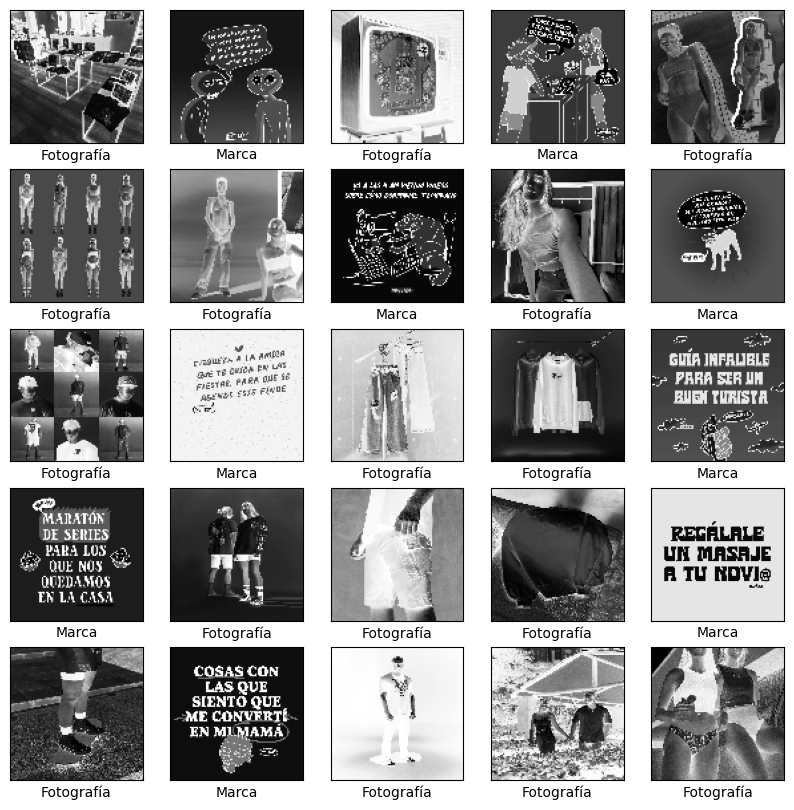

In [9]:
plt.figure(figsize=(10, 10))

for i, (idx, row) in enumerate(df_imagen.head(25).iterrows()):  # Máximo 25 imágenes
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(row['IMAGEN_COD'], cmap=plt.cm.binary)
    plt.xlabel(row['AREA'])

plt.show()

Se observa con que etiquetas contamos para cada una de las imagenes:

In [10]:
etiq = df_imagen['AREA'].unique()
print("etiquetas:", etiq)

df_imagen['AREA'] = df_imagen['AREA'].str.replace('mARCA','Marca') # Se hace una limpieza de las etiquetas 

etiq_recod = df_imagen['AREA'].unique()
print("etiquetas:", etiq_recod)

etiquetas: ['Fotografía' 'Marca' 'Comercial' 'Híbrido' 'mARCA' 'Colaboración']
etiquetas: ['Fotografía' 'Marca' 'Comercial' 'Híbrido' 'Colaboración']


In [ ]:
print("Tamaño del dataframe:",len(df_imagen))

print("Faltantes en las imagenes:",df_imagen['IMAGEN'].isnull().sum())
print("Faltantes en las etiquetas:",df_imagen['AREA'].isnull().sum())


Tamaño del dataframe: 4369
Faltantes en las imagenes: 0
Faltantes en las etiquetas: 0


Etiqueta: AREA
Fotografía      2900
Marca           1223
Comercial        230
Híbrido           14
Colaboración       2
Name: count, dtype: int64


C:\Users\lriverosq\AppData\Local\Temp\ipykernel_4584\44526767.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=conteo_etiquetas.index, y=conteo_etiquetas.values, palette="viridis")


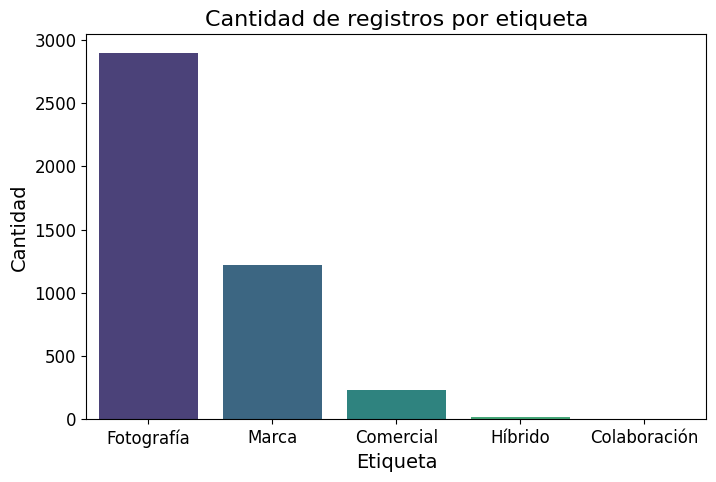

In [12]:
conteo_etiquetas = df_imagen['AREA'].value_counts()
print("Etiqueta:", conteo_etiquetas)
# Crear la gráfica
plt.figure(figsize=(8, 5))
sns.barplot(x=conteo_etiquetas.index, y=conteo_etiquetas.values, palette="viridis")

# Personalizar la gráfica
plt.title('Cantidad de registros por etiqueta', fontsize=16)
plt.xlabel('Etiqueta', fontsize=14)
plt.ylabel('Cantidad', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Mostrar la gráfica
plt.show()

### 3. Modelado

3.1 Procesamiento de la data para el modelado

In [18]:
# Selección de las variables de interes X y Y
X = df_imagen['IMAGEN']
Y = df_imagen['AREA']                           

# Se paración del set de en entrenamiento y validación en un 70% entrenamiento, 30% validación
X_train, X_vald, y_train, y_vald = train_test_split(X, Y, test_size=0.3, random_state=42)

print("Tamaño dataset entrenamiento:", len(y_train))
print("Tamaño dataset validación:", len(y_vald))

Tamaño dataset entrenamiento: 2886
Tamaño dataset validación: 1237


Evaluaremos si tenemos un problema de desbalanceo de clases en el set de entrenamiento:

In [20]:
conteo_etiquetas = y_train.value_counts()
print("Etiqueta:", conteo_etiquetas)

#Proporciñon de cada etiqueta para identificar si hay desbalanceo de clases - umbral de 10%
propor_clases = conteo_etiquetas / len(y_train)
print("Proporción para cada etiqueta",propor_clases)

Etiqueta: AREA
Fotografía    2026
Marca          860
Name: count, dtype: int64
Proporción para cada etiqueta AREA
Fotografía    0.70201
Marca         0.29799
Name: count, dtype: float64


In [21]:
# Se crea un codificador
label_encoder = LabelEncoder()

# Se convierten las etiquetas categóricas a números enteros
y_train = label_encoder.fit_transform(y_train)
y_vald = label_encoder.fit_transform(y_vald)
y_train


array([0, 0, 0, ..., 1, 1, 0])

In [22]:
# Convertir a One-Hot Encoding
y_train = to_categorical(y_train)
y_vald = to_categorical(y_vald)

In [24]:
y_train.shape

(2886, 2)

In [25]:
# Convertimos los datos de la variable independiente en array
X_train_arrays = np.array([cargar_y_preprocesar_imagen(ruta) for ruta in X_train])
X_vald_arrays = np.array([cargar_y_preprocesar_imagen(ruta) for ruta in X_vald])

3.2 Modelado 

3.2.1 Primer modelo - redes convolusionales sin aumento de los datos

In [26]:
from tensorflow.keras.callbacks import TensorBoard

In [27]:
# Se crea el modelo con los parametros necesarios
modelo1 = tf.keras.models.Sequential([ #primera capa convolucional
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(100, 100, 1)), # 32 filtros (nucleos), tamaño de los filtros (3x3) pixeles, 
    #función de activación Rectified Linear Unit, tamaño de la imagen inicial
    tf.keras.layers.MaxPooling2D(2, 2), #primera capa de agrupacion maxima, crea bloques de 2x2, disminuye la complejidad computacional y controla sobre ajuste

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), #segunda capa convolucional, toma 64 filtros
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5), #Apaga el 50% de las neuronas, ayuda al sobre ajuste para no depender de ciertas caracteristicas
    tf.keras.layers.Flatten(), #Convierte las capas en un vector unidimensional
    tf.keras.layers.Dense(100, activation='relu'), #capa densa donde todas las neuronas estan conectadas a la capa anterior
    tf.keras.layers.Dense(2, activation="softmax")  # capa final, por cada numero de clases
])

modelo1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#Adam -> ajusta los pesos del modelo en el entrenamiento, combina los optimizadores SGD y RMSprop
#Loss -> Función de pérdida usada para problemas de clasificación con múltiples clases representadas en formato one-hot encoding.
#metrics -> metrica para evaluar el desempeño del modelo



c:\Users\lriverosq\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
entren1 =modelo1.fit(
    X_train_arrays,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_vald_arrays, y_vald)
   
)


Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 16s 84ms/step - accuracy: 0.7283 - loss: 0.7060 - val_accuracy: 0.8901 - val_loss: 0.3024
Epoch 2/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - accuracy: 0.8933 - loss: 0.2982 - val_accuracy: 0.9014 - val_loss: 0.2682
Epoch 3/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - accuracy: 0.9057 - loss: 0.2575 - val_accuracy: 0.9127 - val_loss: 0.2294
Epoch 4/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.9174 - loss: 0.2223 - val_accuracy: 0.9119 - val_loss: 0.2522
Epoch 5/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step - accuracy: 0.9236 - loss: 0.1835 - val_accuracy: 0.9281 - val_loss: 0.2298
Epoch 6/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - accuracy: 0.9445 - loss: 0.1488 - val_accuracy: 0.9232 - val_loss: 0.2191
Epoch 7/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - accuracy: 0.9652 - loss: 0.1092 - val_accuracy: 0.9103 - val_loss: 0.2606
Epoch 8/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - accuracy: 0.9627 - loss: 0.1046 - val_accuracy: 0

In [ ]:
# Se crea el modelo con los parametros necesarios
modelo2 = tf.keras.models.Sequential([ #primera capa convolucional
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(100, 100, 1)), # 32 filtros (nucleos), tamaño de los filtros (3x3) pixeles, 
    #función de activación Rectified Linear Unit, tamaño de la imagen inicial
    tf.keras.layers.MaxPooling2D(2, 2), #primera capa de agrupacion maxima, crea bloques de 2x2, disminuye la complejidad computacional y controla sobre ajuste

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), #segunda capa convolucional, toma 64 filtros
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), #segunda capa convolucional, toma 64 filtros
    tf.keras.layers.MaxPooling2D(2,2),

    ##tf.keras.layers.Dropout(0.5), #Apaga el 50% de las neuronas, ayuda al sobre ajuste para no depender de ciertas caracteristicas
    tf.keras.layers.Flatten(), #Convierte las capas en un vector unidimensional
    tf.keras.layers.Dense(100, activation='relu'), #capa densa donde todas las neuronas estan conectadas a la capa anterior
    tf.keras.layers.Dense(2, activation="sigmoid")  # capa final, por cada numero de clases
])

modelo2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

entren2 =modelo2.fit(
    X_train_arrays,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_vald_arrays, y_vald)
   
)

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - accuracy: 0.7615 - loss: 0.5919 - val_accuracy: 0.8739 - val_loss: 0.3237
Epoch 2/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.8877 - loss: 0.3075 - val_accuracy: 0.8892 - val_loss: 0.2649
Epoch 3/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.9047 - loss: 0.2339 - val_accuracy: 0.9184 - val_loss: 0.2493
Epoch 4/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.9185 - loss: 0.2155 - val_accuracy: 0.9240 - val_loss: 0.2280
Epoch 5/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - accuracy: 0.9320 - loss: 0.1911 - val_accuracy: 0.9272 - val_loss: 0.2038
Epoch 6/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - accuracy: 0.9312 - loss: 0.1736 - val_accuracy: 0.9248 - val_loss: 0.2545
Epoch 7/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - accuracy: 0.9635 - loss: 0.1153 - val_accuracy: 0.9248 - val_loss: 0.2243
Epoch 8/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.9651 - loss: 0.0961 - val_accuracy: 0

In [30]:
# Se crea el modelo con los parametros necesarios
modelo3 = tf.keras.models.Sequential([ #primera capa convolucional
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(100, 100, 1)), # 32 filtros (nucleos), tamaño de los filtros (3x3) pixeles, 
    #función de activación Rectified Linear Unit, tamaño de la imagen inicial
    tf.keras.layers.MaxPooling2D(2, 2), #primera capa de agrupacion maxima, crea bloques de 2x2, disminuye la complejidad computacional y controla sobre ajuste

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), #segunda capa convolucional, toma 64 filtros
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), #segunda capa convolucional, toma 64 filtros
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5), #Apaga el 50% de las neuronas, ayuda al sobre ajuste para no depender de ciertas caracteristicas
    tf.keras.layers.Flatten(), #Convierte las capas en un vector unidimensional
    tf.keras.layers.Dense(250, activation='relu'), #capa densa donde todas las neuronas estan conectadas a la capa anterior
    tf.keras.layers.Dense(2, activation="sigmoid")  # capa final, por cada numero de clases
])

modelo3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

entren3 =modelo3.fit(
    X_train_arrays,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_vald_arrays, y_vald)
   
)

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.7276 - loss: 0.5483 - val_accuracy: 0.7793 - val_loss: 0.5283
Epoch 2/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.8556 - loss: 0.3521 - val_accuracy: 0.9151 - val_loss: 0.2282
Epoch 3/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9222 - loss: 0.2159 - val_accuracy: 0.9321 - val_loss: 0.1965
Epoch 4/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.9315 - loss: 0.1818 - val_accuracy: 0.9078 - val_loss: 0.2329
Epoch 5/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.9365 - loss: 0.1658 - val_accuracy: 0.9078 - val_loss: 0.2548
Epoch 6/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.9503 - loss: 0.1408 - val_accuracy: 0.9450 - val_loss: 0.1685
Epoch 7/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.9494 - loss: 0.1341 - val_accuracy: 0.9418 - val_loss: 0.1909
Epoch 8/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9609 - loss: 0.1092 - val_accuracy: 0.

In [31]:
# Se crea el modelo con los parametros necesarios
modelo4 = tf.keras.models.Sequential([ #primera capa convolucional
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(100, 100, 1)), # 32 filtros (nucleos), tamaño de los filtros (3x3) pixeles, 
    #función de activación Rectified Linear Unit, tamaño de la imagen inicial
    tf.keras.layers.MaxPooling2D(2, 2), #primera capa de agrupacion maxima, crea bloques de 2x2, disminuye la complejidad computacional y controla sobre ajuste

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), #segunda capa convolucional, toma 64 filtros
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), #segunda capa convolucional, toma 64 filtros
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5), #Apaga el 50% de las neuronas, ayuda al sobre ajuste para no depender de ciertas caracteristicas
    tf.keras.layers.Flatten(), #Convierte las capas en un vector unidimensional
    tf.keras.layers.Dense(250, activation='relu'), #capa densa donde todas las neuronas estan conectadas a la capa anterior
    tf.keras.layers.Dense(2, activation="sigmoid")  # capa final, por cada numero de clases
])

modelo4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


entren4 =modelo4.fit(
    X_train_arrays,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_vald_arrays, y_vald),
    callbacks=[early_stopping]

   
)

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.6900 - loss: 0.6478 - val_accuracy: 0.8852 - val_loss: 0.3112
Epoch 2/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.8931 - loss: 0.2793 - val_accuracy: 0.9151 - val_loss: 0.2467
Epoch 3/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.9101 - loss: 0.2454 - val_accuracy: 0.9256 - val_loss: 0.2344
Epoch 4/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.9320 - loss: 0.2017 - val_accuracy: 0.9135 - val_loss: 0.2209
Epoch 5/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.9414 - loss: 0.1731 - val_accuracy: 0.9086 - val_loss: 0.2315
Epoch 6/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9327 - loss: 0.1753 - val_accuracy: 0.9361 - val_loss: 0.1955
Epoch 7/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9503 - loss: 0.1438 - val_accuracy: 0.9353 - val_loss: 0.1968
Epoch 8/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9556 - loss: 0.1263 - val_accuracy: 0.

In [32]:
# Se amplia el set de datos aplicandole transformaciones a las imagenes para tener mayor variedad en la posición y el tamaño de cada imágen 
# creando nuevas imagenes

rango_rotacion = 30 # Se rotan las imagenes en un angulo de 30 grados
mov_ancho = 0.25 # Se desplazan las imagenes 25% 
mov_alto = 0.25
#rango_inclinacion = 15 #No uso este de momento pero si quieres puedes probar usandolo!
rango_acercamiento=[0.5,1.5] # Se aplica un zoom entre el 50% y el 150% de las imagenes

data_trans = ImageDataGenerator(
    rotation_range = rango_rotacion,
    width_shift_range = mov_ancho,
    height_shift_range = mov_alto,
    zoom_range=rango_acercamiento,
    #shear_range=rango_inclinacion #No uso este de momento pero si quieres puedes probar usandolo!
)

data_trans.fit(X_train_arrays)

# Con esto se tiene mayor variedad de imagenes para evitar sobreajuste 

#Los datos para entrenar saldran del data_trans, de manera que sean generados con las transformaciones de las imagenes
data_trans_entrenamiento = data_trans.flow(X_train_arrays, y_train, batch_size=32)

In [33]:
# Se crea el modelo con los parametros necesarios
modelo5 = tf.keras.models.Sequential([ #primera capa convolucional
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(100, 100, 1)), # 32 filtros (nucleos), tamaño de los filtros (3x3) pixeles, 
    #función de activación Rectified Linear Unit, tamaño de la imagen inicial
    tf.keras.layers.MaxPooling2D(2, 2), #primera capa de agrupacion maxima, crea bloques de 2x2, disminuye la complejidad computacional y controla sobre ajuste

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), #segunda capa convolucional, toma 64 filtros
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5), #Apaga el 50% de las neuronas, ayuda al sobre ajuste para no depender de ciertas caracteristicas
    tf.keras.layers.Flatten(), #Convierte las capas en un vector unidimensional
    tf.keras.layers.Dense(100, activation='relu'), #capa densa donde todas las neuronas estan conectadas a la capa anterior
    tf.keras.layers.Dense(2, activation="softmax")  # capa final, por cada numero de clases
])

modelo5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

entren5 =modelo5.fit(
    data_trans_entrenamiento,
    epochs=100,
    batch_size=32,
    validation_data=(X_vald_arrays, y_vald)
   
)



Epoch 1/100


c:\Users\lriverosq\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.6869 - loss: 0.7108 - val_accuracy: 0.7276 - val_loss: 0.6829
Epoch 2/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.8430 - loss: 0.3834 - val_accuracy: 0.7421 - val_loss: 0.7108
Epoch 3/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.8555 - loss: 0.3621 - val_accuracy: 0.8157 - val_loss: 0.5146
Epoch 4/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.8809 - loss: 0.3087 - val_accuracy: 0.7979 - val_loss: 0.5089
Epoch 5/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.8890 - loss: 0.2920 - val_accuracy: 0.8076 - val_loss: 0.5043
Epoch 6/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.8993 - loss: 0.2740 - val_accuracy: 0.7146 - val_loss: 0.6975
Epoch 7/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.8955 - loss: 0.2869 - val_accuracy: 0.7825 - val_loss: 0.6334
Epoch 8/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.8855 - loss: 0.2985 - val_accuracy: 0.8504 - val_l

In [34]:
# Se crea el modelo con los parametros necesarios
modelo6 = tf.keras.models.Sequential([ #primera capa convolucional
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(100, 100, 1)), # 32 filtros (nucleos), tamaño de los filtros (3x3) pixeles, 
    #función de activación Rectified Linear Unit, tamaño de la imagen inicial
    tf.keras.layers.MaxPooling2D(2, 2), #primera capa de agrupacion maxima, crea bloques de 2x2, disminuye la complejidad computacional y controla sobre ajuste

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), #segunda capa convolucional, toma 64 filtros
    tf.keras.layers.MaxPooling2D(2,2),

     tf.keras.layers.Conv2D(128, (3,3), activation='relu'), #segunda capa convolucional, toma 64 filtros
    tf.keras.layers.MaxPooling2D(2,2),

    ##tf.keras.layers.Dropout(0.5), #Apaga el 50% de las neuronas, ayuda al sobre ajuste para no depender de ciertas caracteristicas
    tf.keras.layers.Flatten(), #Convierte las capas en un vector unidimensional
    tf.keras.layers.Dense(100, activation='relu'), #capa densa donde todas las neuronas estan conectadas a la capa anterior
    tf.keras.layers.Dense(2, activation="sigmoid")  # capa final, por cada numero de clases
])

modelo6.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

entren6 =modelo6.fit(
    data_trans_entrenamiento,
    epochs=100,
    batch_size=32,
    validation_data=(X_vald_arrays, y_vald)
   
)

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.6660 - loss: 0.6427 - val_accuracy: 0.7591 - val_loss: 0.4688
Epoch 2/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.8256 - loss: 0.4289 - val_accuracy: 0.7381 - val_loss: 0.6433
Epoch 3/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.8494 - loss: 0.3693 - val_accuracy: 0.7777 - val_loss: 0.6506
Epoch 4/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.8795 - loss: 0.3082 - val_accuracy: 0.7454 - val_loss: 0.7260
Epoch 5/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.8756 - loss: 0.3117 - val_accuracy: 0.8779 - val_loss: 0.3687
Epoch 6/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.9034 - loss: 0.2837 - val_accuracy: 0.7470 - val_loss: 0.6558
Epoch 7/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.8978 - loss: 0.2714 - val_accuracy: 0.8715 - val_loss: 0.3974
Epoch 8/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.8948 - loss: 0.2767 - val_accuracy: 0.

In [35]:
# Se crea el modelo con los parametros necesarios
modelo7 = tf.keras.models.Sequential([ #primera capa convolucional
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(100, 100, 1)), # 32 filtros (nucleos), tamaño de los filtros (3x3) pixeles, 
    #función de activación Rectified Linear Unit, tamaño de la imagen inicial
    tf.keras.layers.MaxPooling2D(2, 2), #primera capa de agrupacion maxima, crea bloques de 2x2, disminuye la complejidad computacional y controla sobre ajuste

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), #segunda capa convolucional, toma 64 filtros
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), #segunda capa convolucional, toma 64 filtros
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5), #Apaga el 50% de las neuronas, ayuda al sobre ajuste para no depender de ciertas caracteristicas
    tf.keras.layers.Flatten(), #Convierte las capas en un vector unidimensional
    tf.keras.layers.Dense(250, activation='relu'), #capa densa donde todas las neuronas estan conectadas a la capa anterior
    tf.keras.layers.Dense(2, activation="sigmoid")  # capa final, por cada numero de clases
])

modelo7.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


entren7 =modelo7.fit(
    data_trans_entrenamiento,
    epochs=100,
    batch_size=32,
    validation_data=(X_vald_arrays, y_vald),
    callbacks=[early_stopping]

   
)

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.7266 - loss: 0.5572 - val_accuracy: 0.8302 - val_loss: 0.4177
Epoch 2/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.8753 - loss: 0.3286 - val_accuracy: 0.9054 - val_loss: 0.2979
Epoch 3/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.8769 - loss: 0.3312 - val_accuracy: 0.8989 - val_loss: 0.3057
Epoch 4/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.8783 - loss: 0.3194 - val_accuracy: 0.7704 - val_loss: 0.6890
Epoch 5/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.8983 - loss: 0.2755 - val_accuracy: 0.7559 - val_loss: 0.7018
Epoch 6/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.9103 - loss: 0.2487 - val_accuracy: 0.8820 - val_loss: 0.3342
Epoch 7/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.8976 - loss: 0.2789 - val_accuracy: 0.8480 - val_loss: 0.4236


### 4. Validación

In [36]:
# Evaluar modelos en los datos de prueba
loss_model1, accuracy_model1 = modelo1.evaluate(X_vald_arrays, y_vald)
loss_model2, accuracy_model2 = modelo2.evaluate(X_vald_arrays, y_vald)
loss_model3, accuracy_model3 = modelo3.evaluate(X_vald_arrays, y_vald)
loss_model4, accuracy_model4 = modelo4.evaluate(X_vald_arrays, y_vald)
loss_model5, accuracy_model5 = modelo5.evaluate(X_vald_arrays, y_vald)
loss_model6, accuracy_model6 = modelo6.evaluate(X_vald_arrays, y_vald)
loss_model7, accuracy_model7 = modelo7.evaluate(X_vald_arrays, y_vald)


print(f"Modelo 1: Loss={loss_model1}, Accuracy={accuracy_model1}")
print(f"Modelo 2: Loss={loss_model2}, Accuracy={accuracy_model2}")
print(f"Modelo 3: Loss={loss_model3}, Accuracy={accuracy_model3}")
print(f"Modelo 4: Loss={loss_model4}, Accuracy={accuracy_model4}")
print(f"Modelo 5: Loss={loss_model5}, Accuracy={accuracy_model5}")
print(f"Modelo 6: Loss={loss_model6}, Accuracy={accuracy_model6}")
print(f"Modelo 7: Loss={loss_model7}, Accuracy={accuracy_model7}")

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9256 - loss: 0.6330
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9269 - loss: 0.8458
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9458 - loss: 0.5507
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9325 - loss: 0.1913
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8549 - loss: 0.5205
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8962 - loss: 0.3411
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9084 - loss: 0.3059
Modelo 1: Loss=0.6538092494010925, Accuracy=0.9272433519363403
Modelo 2: Loss=0.8829346895217896, Accuracy=0.9288601279258728
Modelo 3: Loss=0.6233267188072205, Accuracy=0.9409862756729126
Modelo 4: Loss=0.19553719460964203, Accuracy=0.9361358284950256
Modelo 5: Loss=0.525310218334198, Accuracy=0.8649959564208984
Modelo 6: Loss=0.31716740131378174, Accuracy=0.9086499810218811
Modelo 7: Loss=0.29793745279312134, Accuracy=0.9054163098335266


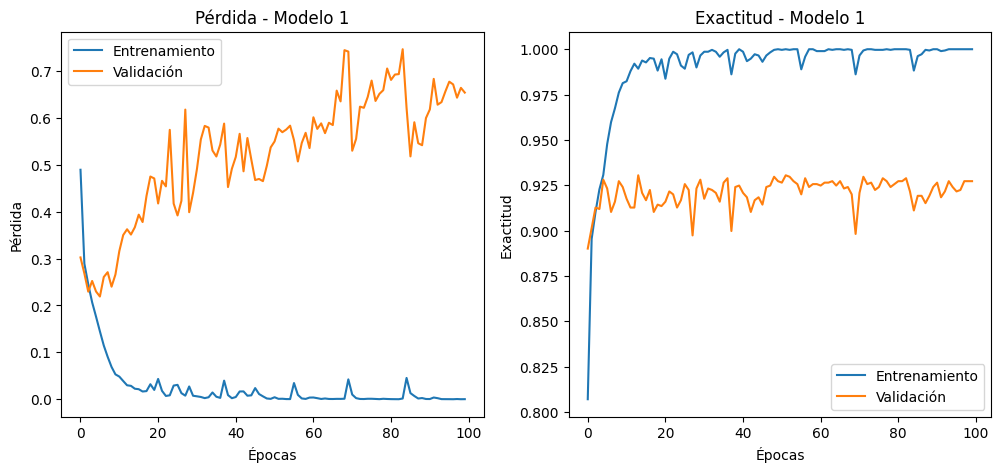

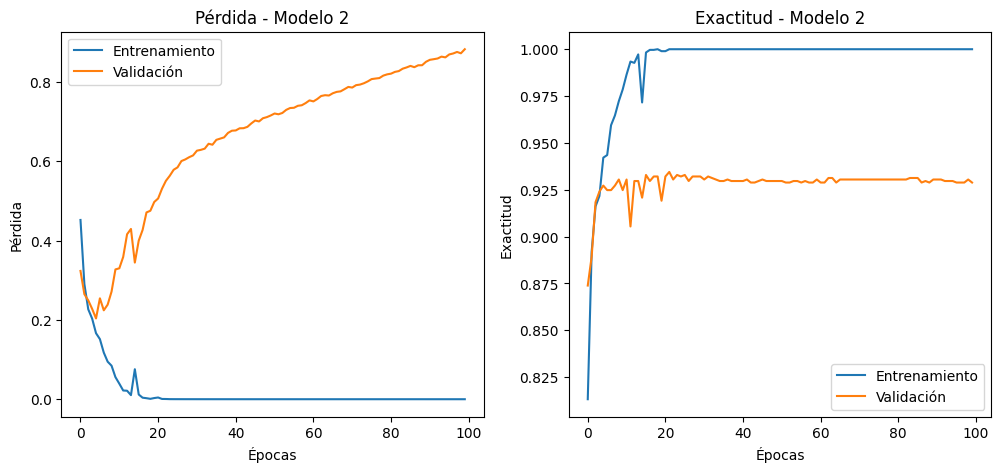

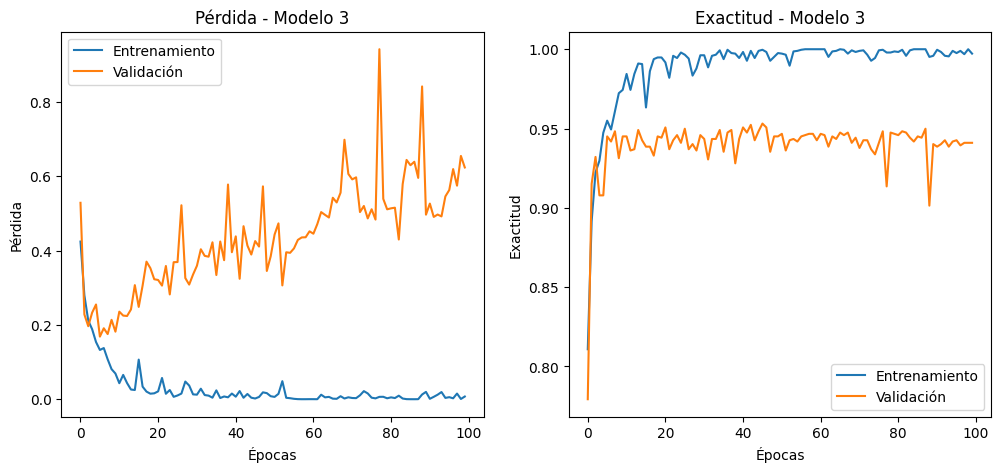

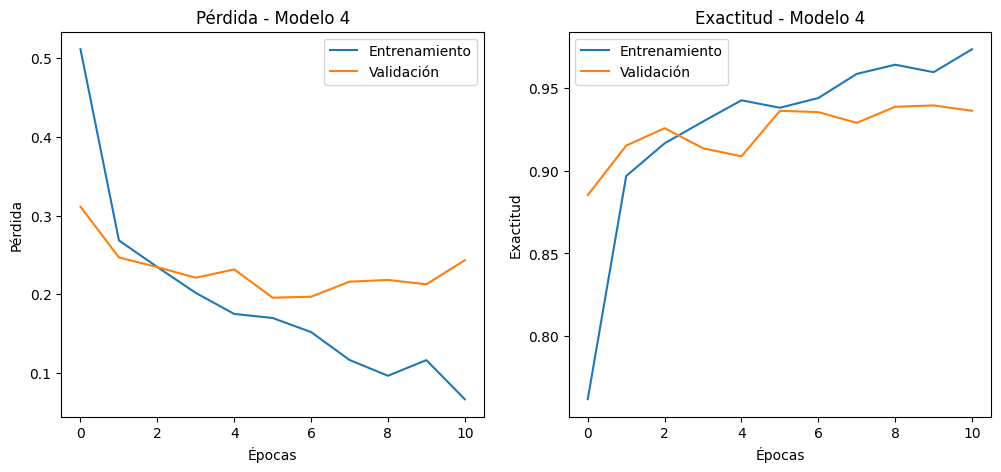

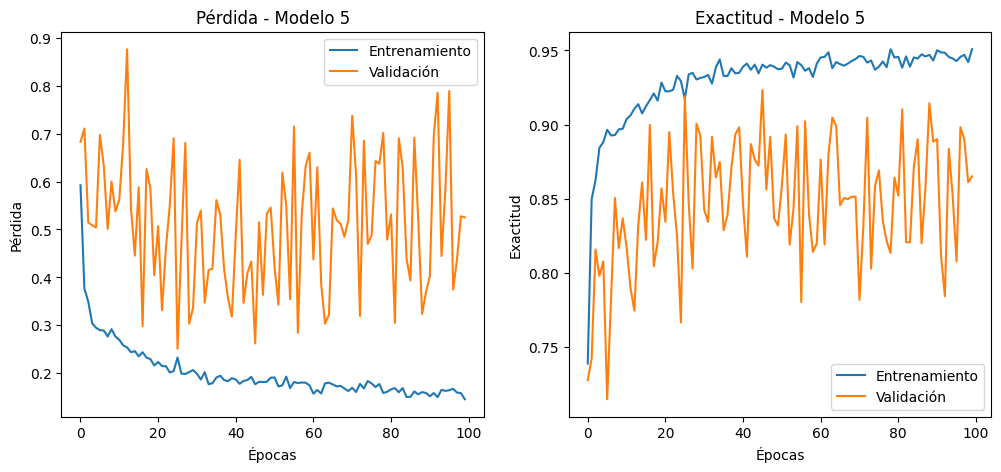

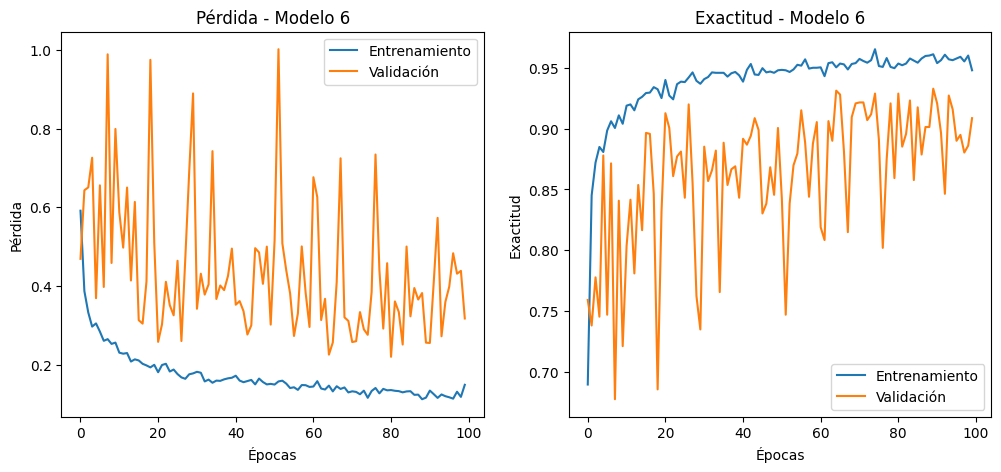

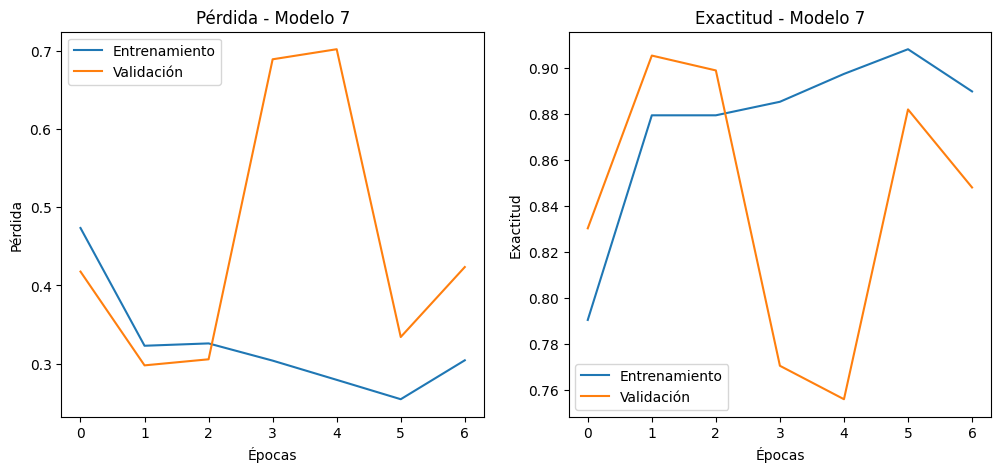

In [37]:
import matplotlib.pyplot as plt

def plot_history(history, title="Modelo"):
    plt.figure(figsize=(12, 5))
    
    # Pérdida
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Entrenamiento')
    plt.plot(history.history['val_loss'], label='Validación')
    plt.title(f'Pérdida - {title}')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()

    # Exactitud
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Validación')
    plt.title(f'Exactitud - {title}')
    plt.xlabel('Épocas')
    plt.ylabel('Exactitud')
    plt.legend()

    plt.show()

# Graficar para cada modelo
plot_history(entren1, "Modelo 1")
plot_history(entren2, "Modelo 2")
plot_history(entren3, "Modelo 3")
plot_history(entren4, "Modelo 4")
plot_history(entren5, "Modelo 5")
plot_history(entren6, "Modelo 6")
plot_history(entren7, "Modelo 7")

In [94]:
predicciones6 = modelo6.predict(X_vald_arrays)
clases_predichas6 = np.argmax(predicciones6, axis=1)
pérdida6, exactitud6 = modelo6.evaluate(X_vald_arrays, y_vald)
print(f"Pérdida: {pérdida6}, Exactitud: {exactitud6}")

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8962 - loss: 0.3411
Pérdida: 0.31716740131378174, Exactitud: 0.9086499810218811


In [90]:
y_vald_unidimensional = np.argmax(y_vald, axis=1)

In [95]:
predicciones6_bin = predicciones6.argmax(axis=1)
f1 = f1_score(y_vald_unidimensional, predicciones6_bin, average='binary') 

print(f"F1-Score: {f1:.2f}")

F1-Score: 0.86


In [96]:
matriz_confucion6 = confusion_matrix(y_vald_unidimensional, predicciones6_bin)
matriz_confucion6

array([[779,  95],
       [ 18, 345]])

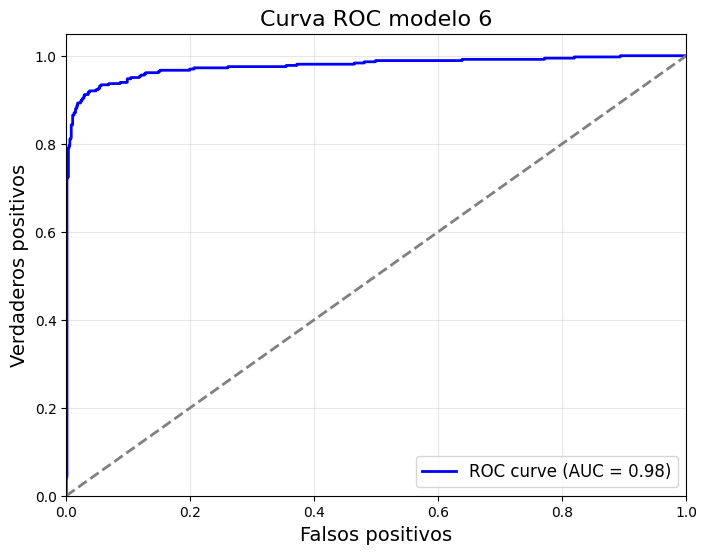

In [97]:
probabilidades_clase_positiva6 = predicciones6[:, 1]
fpr, tpr, thresholds = roc_curve(y_vald_unidimensional, probabilidades_clase_positiva6)
roc_auc = auc(fpr, tpr)

# Grafica la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Línea diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Falsos positivos', fontsize=14)
plt.ylabel('Verdaderos positivos', fontsize=14)
plt.title('Curva ROC modelo 6', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

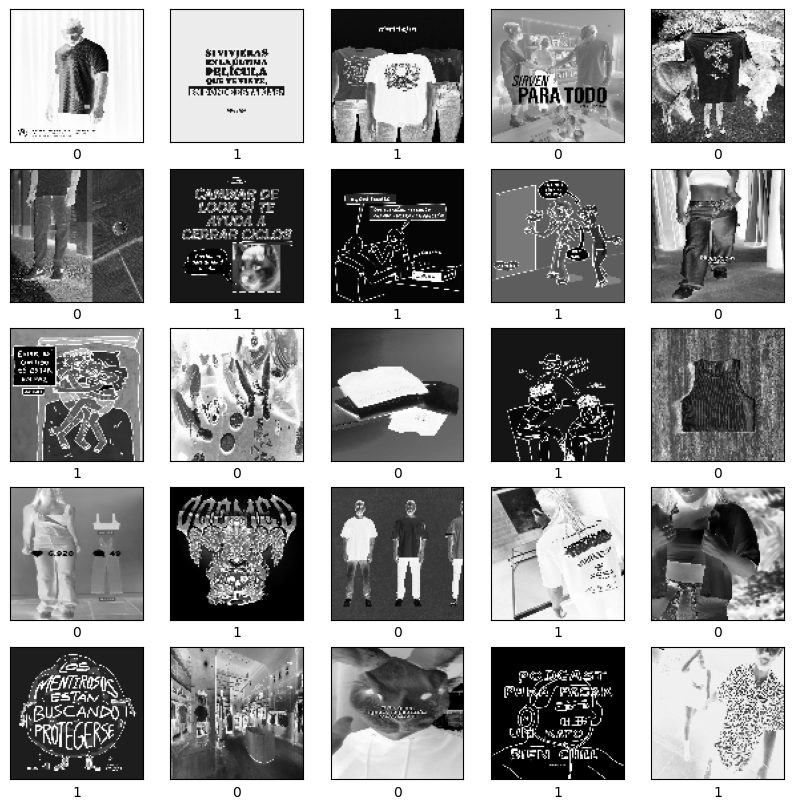

In [290]:
# Imagenes en escala de grises con su clasificación 
plt.figure(figsize=(10, 10))

for i, (idx, row) in enumerate(df_imagen.head(25).iterrows()):  # Máximo 25 imágenes
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_vald_arrays[i], cmap=plt.cm.binary)
    plt.xlabel(clases_predichas6[i])

plt.show()

In [81]:
predicciones4 = modelo4.predict(X_vald_arrays)
clases_predichas4 = np.argmax(predicciones4, axis=1)
pérdida4, exactitud4 = modelo4.evaluate(X_vald_arrays, y_vald)
print(f"Pérdida: {pérdida4}, Exactitud: {exactitud4}")

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9325 - loss: 0.1913
Pérdida: 0.19553719460964203, Exactitud: 0.9361358284950256


In [82]:
predicciones4_bin = predicciones4.argmax(axis=1)
f1 = f1_score(y_vald_unidimensional, predicciones4_bin, average='binary') 

print(f"F1-Score: {f1:.2f}")

F1-Score: 0.89


In [83]:
matriz_confucion4 = confusion_matrix(y_vald_unidimensional, predicciones4_bin)
matriz_confucion4

array([[841,  33],
       [ 46, 317]])

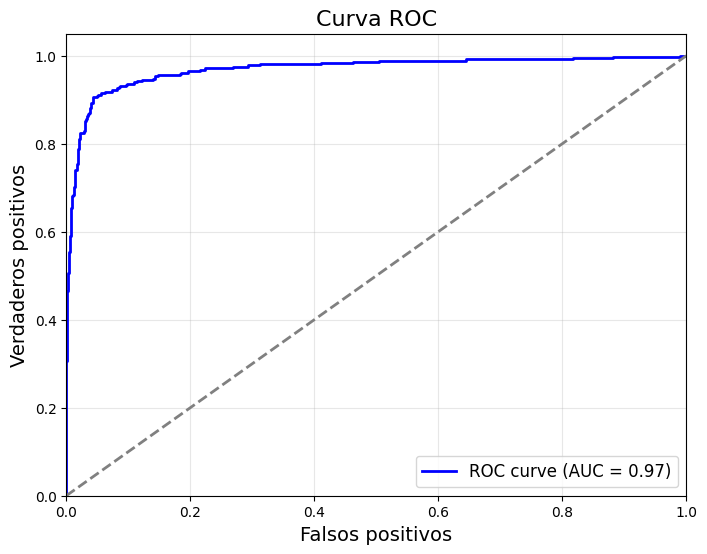

In [88]:
probabilidades_clase_positiva4 = predicciones4[:, 1]
fpr, tpr, thresholds = roc_curve(y_vald_unidimensional, probabilidades_clase_positiva4)
roc_auc = auc(fpr, tpr)

# Grafica la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Línea diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Falsos positivos', fontsize=14)
plt.ylabel('Verdaderos positivos', fontsize=14)
plt.title('Curva ROC', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

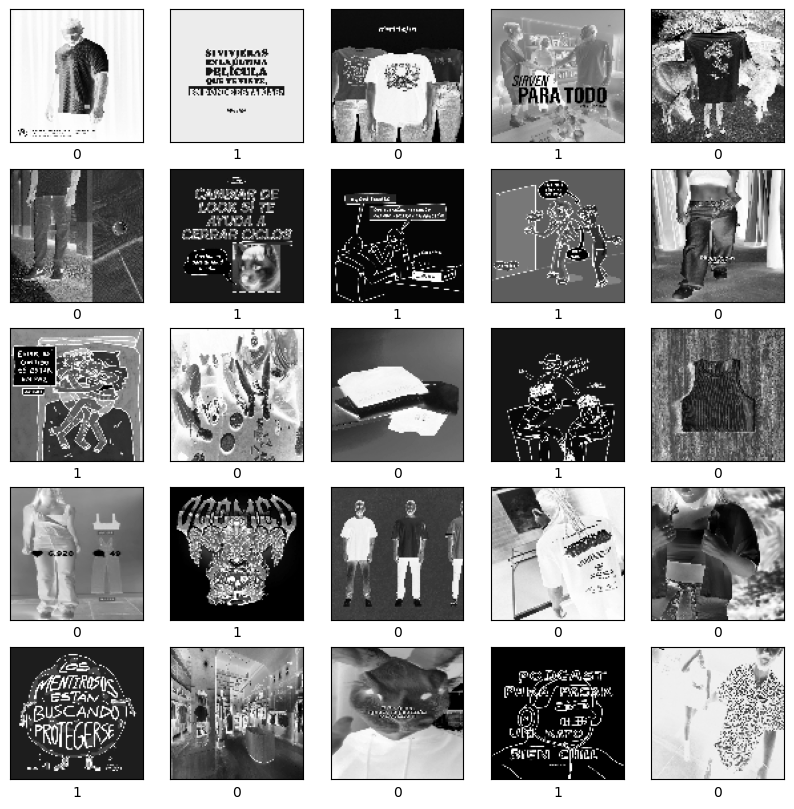

In [54]:
# Imagenes en escala de grises con su clasificación 
plt.figure(figsize=(10, 10))

for i, (idx, row) in enumerate(df_imagen.head(25).iterrows()):  # Máximo 25 imágenes
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_vald_arrays[i], cmap=plt.cm.binary)
    plt.xlabel(clases_predichas4[i])

plt.show()

### 5. Datos de prueba

In [109]:
# Leemos los datos de prueba que provienen de un archivo tipo json de la API de meta (Instagram)
file_path2 = "C:/Users/lriverosq/Downloads/instagram_comments.media.csv"
bd_prueba = pd.read_csv(file_path2, sep = ",")
bd_prueba.head()

_id                 id  comments_count  like_count  \
0  6720216abe52b3b5bafd5c25  17885546880137184               4        2046   
1  6720222cbe52b3b5bafd5c27  18309295885163455               7        5107   
2  67202235be52b3b5bafd5c28  18112330036418818               5        1108   
3  67203668be52b3b5bafd5c2b  18113442424416177             136       42744   
4  67203672be52b3b5bafd5c6b  17935214105926683               6        1487   

                                           media_url  
0  https://scontent-bog2-2.cdninstagram.com/o1/v/...  
1  https://scontent-bog2-2.cdninstagram.com/v/t51...  
2  https://scontent-bog2-2.cdninstagram.com/o1/v/...  
3  https://scontent-bog2-1.cdninstagram.com/v/t39...  
4  https://scontent.cdninstagram.com/v/t51.75761-...

In [111]:
imagenes_sin_video_url = bd_prueba[~bd_prueba['media_url'].str.contains("video", case=False, na=False)]
imagenes_sin_video_url.head()


_id                 id  comments_count  like_count  \
1  6720222cbe52b3b5bafd5c27  18309295885163455               7        5107   
3  67203668be52b3b5bafd5c2b  18113442424416177             136       42744   
4  67203672be52b3b5bafd5c6b  17935214105926683               6        1487   
6  6720369fbe52b3b5bafd5c8a  18051091720925441              20        3314   
7  672036a8be52b3b5bafd5c90  17968410419666363               0        1870   

                                           media_url  
1  https://scontent-bog2-2.cdninstagram.com/v/t51...  
3  https://scontent-bog2-1.cdninstagram.com/v/t39...  
4  https://scontent.cdninstagram.com/v/t51.75761-...  
6  https://scontent-bog2-1.cdninstagram.com/v/t51...  
7  https://scontent-bog2-1.cdninstagram.com/v/t51...

In [112]:
import requests
from PIL import Image
from io import BytesIO

def descargar_imagen(url):
    try:
        response = requests.get(url)
        if response.status_code == 200:
            return Image.open(BytesIO(response.content))
        else:
            return None
    except Exception as e:
        print(f"Error al descargar la URL {url}: {e}")
        return None

# Crear una nueva columna con las imágenes descargadas
bd_prueba['imagen'] = bd_prueba['media_url'].apply(descargar_imagen)

Error al descargar la URL https://scontent-bog2-2.cdninstagram.com/o1/v/t16/f1/m86/0243D10803B5AF9F225ED28ED389579A_video_dashinit.mp4?efg=eyJ2ZW5jb2RlX3RhZyI6InZ0c192b2RfdXJsZ2VuLmNsaXBzLnVua25vd24tQzMuNzIwLmRhc2hfYmFzZWxpbmVfMV92MSJ9&_nc_ht=scontent-bog2-2.cdninstagram.com&_nc_cat=105&vs=411837398257489_2615596710&_nc_vs=HBksFQIYUmlnX3hwdl9yZWVsc19wZXJtYW5lbnRfc3JfcHJvZC8wMjQzRDEwODAzQjVBRjlGMjI1RUQyOEVEMzg5NTc5QV92aWRlb19kYXNoaW5pdC5tcDQVAALIAQAVAhg6cGFzc3Rocm91Z2hfZXZlcnN0b3JlL0dOVUVkUnVQNG9icDNNVURBTGFISnp1SmQwUmVicV9FQUFBRhUCAsgBACgAGAAbAYgHdXNlX29pbAExFQAAJrzktseCxptAFQIoAkMzLBdAUdSLQ5WBBhgSZGFzaF9iYXNlbGluZV8xX3YxEQB1AAA%3D&ccb=9-4&oh=00_AYBn1Vu6ob9hqbVh0J_x1crSo_epNXRdN2XnEWjZgvd94g&oe=674296B1&_nc_sid=1d576d: cannot identify image file <_io.BytesIO object at 0x0000014D9083EA20>
Error al descargar la URL nan: Invalid URL 'nan': No scheme supplied. Perhaps you meant https://nan?
Error al descargar la URL nan: Invalid URL 'nan': No scheme supplied. Perhaps you meant https://nan?

In [123]:
print("Tamaño del dataframe:",len(bd_prueba))
print("Faltantes de lectura de URL:",bd_prueba['media_url'].isnull().sum())


Tamaño del dataframe: 2895
Faltantes de lectura de URL: 143


In [117]:
import cv2

def cargar_y_preprocesar_imagen_ipl(imagen_ipl):
    try:
        if len(imagen_ipl.shape) == 3:
            imagen_ipl = cv2.cvtColor(imagen_ipl, cv2.COLOR_BGR2GRAY)
            imagen_ipl = cv2.resize(imagen_ipl, (100, 100))
            imagen_normalizada = imagen_ipl / 255.0
            imagen_array = np.array(imagen_normalizada, dtype=np.float32)
        
        return imagen_array
    except Exception as e:
        print(f"Error al procesar la imagen IPL: {e}")
        return None

bd_prueba['imagen_cod'] = bd_prueba['imagen'].apply(cargar_y_preprocesar_imagen_ipl)


Error al procesar la imagen IPL: 'NoneType' object has no attribute 'shape'
Error al procesar la imagen IPL: 'JpegImageFile' object has no attribute 'shape'
Error al procesar la imagen IPL: 'NoneType' object has no attribute 'shape'
Error al procesar la imagen IPL: 'JpegImageFile' object has no attribute 'shape'
Error al procesar la imagen IPL: 'NoneType' object has no attribute 'shape'
Error al procesar la imagen IPL: 'NoneType' object has no attribute 'shape'
Error al procesar la imagen IPL: 'JpegImageFile' object has no attribute 'shape'
Error al procesar la imagen IPL: 'JpegImageFile' object has no attribute 'shape'
Error al procesar la imagen IPL: 'JpegImageFile' object has no attribute 'shape'
Error al procesar la imagen IPL: 'JpegImageFile' object has no attribute 'shape'
Error al procesar la imagen IPL: 'JpegImageFile' object has no attribute 'shape'
Error al procesar la imagen IPL: 'JpegImageFile' object has no attribute 'shape'
Error al procesar la imagen IPL: 'JpegImageFile'

In [ ]:
def preprocesar_imagen(imagen_pil):
    try:
        # Verificar si la imagen es None
        if imagen_pil is None:
            raise ValueError("La imagen es None.")

        imagen = tf.keras.preprocessing.image.img_to_array(imagen_pil)

        if imagen.shape[-1] > 1:  
            imagen = tf.image.rgb_to_grayscale(imagen)
        imagen = tf.image.resize(imagen, [100, 100])
        imagen = tf.keras.utils.img_to_array(imagen) # Cargar array
        imagen = imagen / 255

        return imagen
    except Exception as e:
        print(f"Error al preprocesar la imagen: {e}")
        return None

# Aplicar la función de preprocesamiento a la columna de imágenes
bd_prueba['imagen_cod'] = bd_prueba['imagen'].apply(preprocesar_imagen)


Error al preprocesar la imagen: La imagen es None.
Error al preprocesar la imagen: La imagen es None.
Error al preprocesar la imagen: La imagen es None.
Error al preprocesar la imagen: La imagen es None.
Error al preprocesar la imagen: La imagen es None.
Error al preprocesar la imagen: La imagen es None.
Error al preprocesar la imagen: La imagen es None.
Error al preprocesar la imagen: La imagen es None.
Error al preprocesar la imagen: La imagen es None.
Error al preprocesar la imagen: La imagen es None.
Error al preprocesar la imagen: La imagen es None.
Error al preprocesar la imagen: La imagen es None.
Error al preprocesar la imagen: La imagen es None.
Error al preprocesar la imagen: La imagen es None.
Error al preprocesar la imagen: La imagen es None.
Error al preprocesar la imagen: La imagen es None.
Error al preprocesar la imagen: La imagen es None.
Error al preprocesar la imagen: La imagen es None.
Error al preprocesar la imagen: La imagen es None.
Error al preprocesar la imagen:

In [130]:
print("Faltantes de lectura de URL:",bd_prueba['imagen_cod'].isnull().sum())


Faltantes de lectura de URL: 453


In [132]:
bd_prueba = bd_prueba[bd_prueba['imagen_cod'].notnull()]  # Eliminar filas con valores None en la columna
print("Faltantes de lectura de URL:",bd_prueba['imagen_cod'].isnull().sum())

Faltantes de lectura de URL: 0


In [142]:
X_test_arrays = np.array(bd_prueba['imagen_cod'].to_list())



In [143]:
X_test_arrays

array([[[[0.6314803 ],
         [0.6451708 ],
         [0.6517461 ],
         ...,
         [0.9076662 ],
         [0.90864646],
         [0.90648943]],

        [[0.6481453 ],
         [0.64928806],
         [0.66095245],
         ...,
         [0.9027648 ],
         [0.90864646],
         [0.89551044]],

        [[0.6538944 ],
         [0.6607564 ],
         [0.6690712 ],
         ...,
         [0.9076662 ],
         [0.9059009 ],
         [0.9119796 ]],

        ...,

        [[0.09441565],
         [0.07979321],
         [0.0801499 ],
         ...,
         [0.05504598],
         [0.05602628],
         [0.05602628]],

        [[0.07936567],
         [0.07897355],
         [0.08603166],
         ...,
         [0.05602628],
         [0.05602628],
         [0.05602628]],

        [[0.09132526],
         [0.09234098],
         [0.08603166],
         ...,
         [0.05308539],
         [0.05622253],
         [0.05543824]]],


       [[[0.        ],
         [0.        ],
         [0.  

In [144]:
predicciones = modelo4.predict(X_test_arrays)
clases_predichas = np.argmax(predicciones, axis=1)

77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step


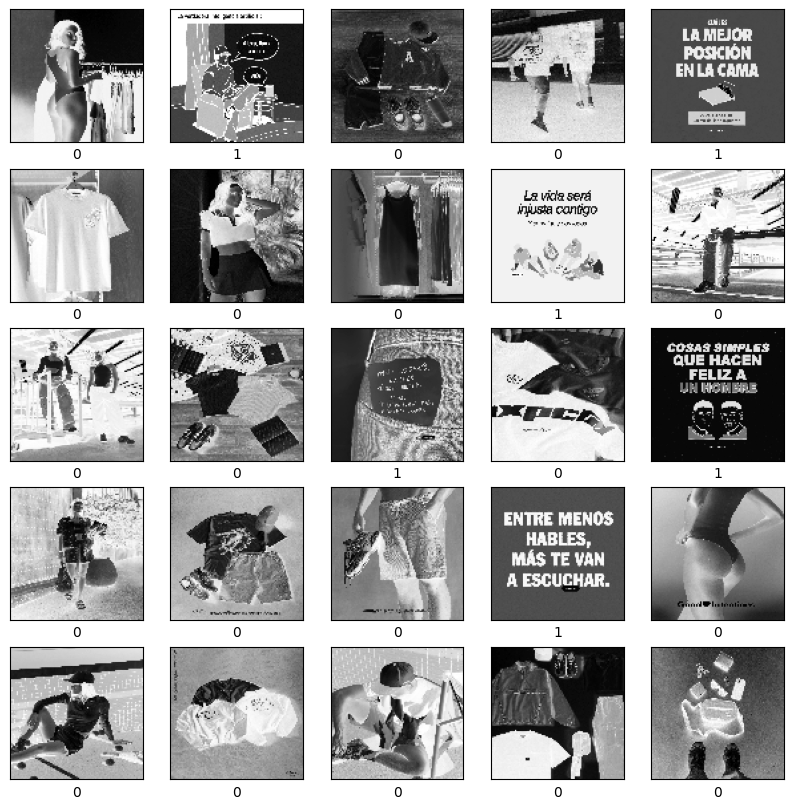

In [145]:
# Imagenes en escala de grises con su clasificación 
plt.figure(figsize=(10, 10))

for i, (idx, row) in enumerate(bd_prueba.head(25).iterrows()):  # Máximo 25 imágenes
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test_arrays[i], cmap=plt.cm.binary)
    plt.xlabel(clases_predichas[i])

plt.show()

In [147]:
bd_prueba['clasificacion'] = clases_predichas

C:\Users\lriverosq\AppData\Local\Temp\ipykernel_4584\3772196251.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bd_prueba['clasificacion'] = clases_predichas


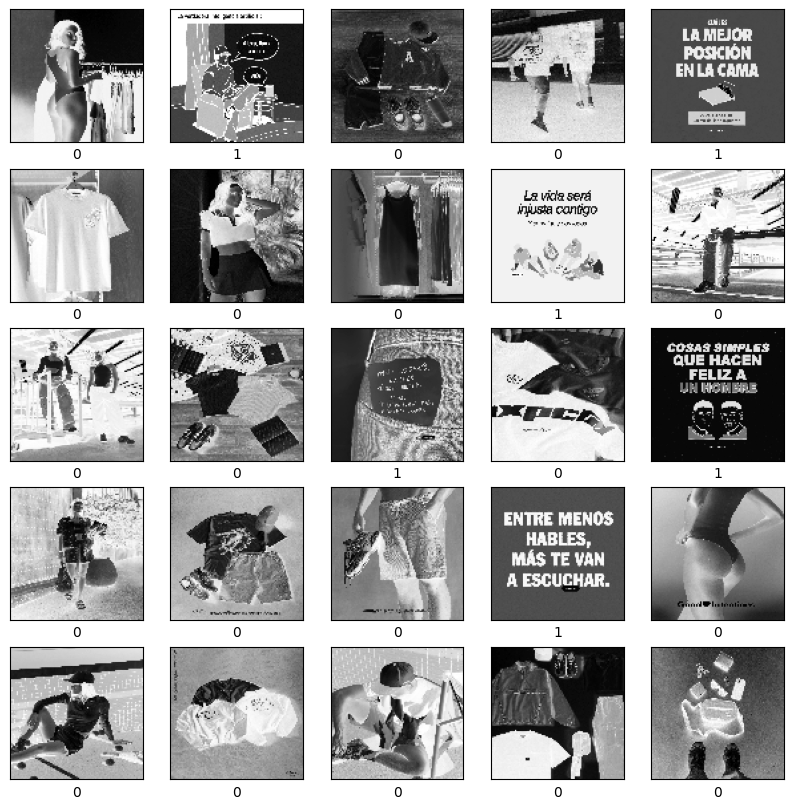

In [150]:
plt.figure(figsize=(10, 10))

for i, (idx, row) in enumerate(bd_prueba.head(25).iterrows()):  # Máximo 25 imágenes
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(row['imagen_cod'], cmap=plt.cm.binary)
    plt.xlabel(row['clasificacion'])

plt.show()

### 6. Analisis de sentimientos

Importamos los comentarios referentes a cada publicación

In [153]:
file_path3 = "C:/Users/lriverosq/Downloads/instagram_comments.media_comments.csv"
bd_comments = pd.read_csv(file_path3, sep = ",")
bd_comments.head(5)

C:\Users\lriverosq\AppData\Local\Temp\ipykernel_4584\927105779.py:2: DtypeWarning: Columns (13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,106,107) have mixed types. Specify dtype option on import or set low_memory=False.
  bd_comments = pd.read_csv(file_path3, sep = ",")


_id                 id           media.id  \
0  6720221cbe52b3b5bafd5c26  17886088542133131  17885546880137184   
1  672035adbe52b3b5bafd5c29  18020065433309682  17885546880137184   
2  672035b7be52b3b5bafd5c2a  17984076446744479  18309295885163455   
3  67203668be52b3b5bafd5c2c  18020708999287606  18113442424416177   
4  67203668be52b3b5bafd5c2d  18025406222415636  18113442424416177   

                                                text  \
0                                                🔥🔥🔥   
1                                                😂😂😂   
2  Muy lindo pero que tal ese body en rosa ,lila ...   
3                                       ok mattelsa.   
4                                               😂😂😂😂   

                  timestamp       username replies.data[0].text  \
0  2024-10-28T22:16:18+0000   pauligarcia8                  NaN   
1  2024-10-28T23:55:24+0000       caas8703                  NaN   
2  2024-10-29T00:43:59+0000    tatiana02br                  NaN   
3  2024-10-28T22:47:27+0000     cxhrystian                  NaN   
4  2024-10-28T22:19:26+0000  mafegalarza05                  NaN   

  replies.data[1].text replies.data[2].text replies.data[3].text  ...  \
0                  NaN                  NaN                  NaN  ...   
1                  NaN                  NaN                  NaN  ...   
2                  NaN                  NaN                  NaN  ...   
3                  NaN                  NaN                  NaN  ...   
4                  NaN                  NaN                  NaN  ...   

  replies.data[17].id replies.data[18].id replies.data[19].id  \
0                 NaN                 NaN                 NaN   
1                 NaN                 NaN                 NaN   
2                 NaN                 NaN                 NaN   
3                 NaN                 NaN                 NaN   
4                 NaN                 NaN                 NaN   

  replies.data[20].id replies.data[21].id replies.data[22].id  \
0                 NaN                 NaN                 NaN   
1                 NaN                 NaN                 NaN   
2                 NaN                 NaN                 NaN   
3                 NaN                 NaN                 NaN   
4                 NaN                 NaN                 NaN   

  replies.data[23].id replies.data[24].id replies.paging.cursors.after  \
0                 NaN                 NaN                          NaN   
1                 NaN                 NaN                          NaN   
2                 NaN                 NaN                          NaN   
3                 NaN                 NaN                          NaN   
4                 NaN                 NaN                          NaN   

  replies.paging.next  
0                 NaN  
1                 NaN  
2                 NaN  
3                 NaN  
4                 NaN  

[5 rows x 108 columns]

Unimos los dos dataframe, bd_prueba con las imagenes y su clasificación y el dataframe bd_comments para identificar los comentarios correspondientes a cada imagen y su clasificación:

In [156]:
bd = pd.merge(bd_comments, bd_prueba, how = 'right', left_on= 'media.id',  right_on = 'id')
bd.head()

_id_x          id_x      media.id  \
0  672035b7be52b3b5bafd5c2a  1.798408e+16  1.830930e+16   
1  67214842be52b3b5bafd95e8  1.787334e+16  1.830930e+16   
2  67214842be52b3b5bafd95e9  1.798180e+16  1.830930e+16   
3  673b95aebe52b3b5ba01b557  1.825890e+16  1.830930e+16   
4  673b95aebe52b3b5ba01b558  1.847023e+16  1.830930e+16   

                                                text  \
0  Muy lindo pero que tal ese body en rosa ,lila ...   
1                          Se parece a @cvillaloboss   
2             Hola que precio tiene el 1 por fis 😍😍🔥   
3                                @anamhdzc que tal 😌   
4  Hola el body de manga larga esta en la tienda ...   

                  timestamp          username  \
0  2024-10-29T00:43:59+0000       tatiana02br   
1  2024-10-29T18:07:19+0000         isesmeral   
2  2024-10-29T17:06:24+0000  alejithakrtagena   
3  2024-10-30T17:25:11+0000          kegonzha   
4  2024-10-30T03:27:17+0000        mpilarcj88   

                     replies.data[0].text replies.data[1].text  \
0                                     NaN                  NaN   
1                                     NaN                  NaN   
2              @alejithakrtagena $79.000🔥                  NaN   
3                                     NaN                  NaN   
4  @mpilarcj88 Sii, en todas las tallas 😏                  NaN   

  replies.data[2].text replies.data[3].text  ... replies.paging.cursors.after  \
0                  NaN                  NaN  ...                          NaN   
1                  NaN                  NaN  ...                          NaN   
2                  NaN                  NaN  ...                          NaN   
3                  NaN                  NaN  ...                          NaN   
4                  NaN                  NaN  ...                          NaN   

  replies.paging.next                     _id_y               id_y  \
0                 NaN  6720222cbe52b3b5bafd5c27  18309295885163455   
1                 NaN  6720222cbe52b3b5bafd5c27  18309295885163455   
2                 NaN  6720222cbe52b3b5bafd5c27  18309295885163455   
3                 NaN  6720222cbe52b3b5bafd5c27  18309295885163455   
4                 NaN  6720222cbe52b3b5bafd5c27  18309295885163455   

  comments_count like_count  \
0              7       5107   
1              7       5107   
2              7       5107   
3              7       5107   
4              7       5107   

                                           media_url  \
0  https://scontent-bog2-2.cdninstagram.com/v/t51...   
1  https://scontent-bog2-2.cdninstagram.com/v/t51...   
2  https://scontent-bog2-2.cdninstagram.com/v/t51...   
3  https://scontent-bog2-2.cdninstagram.com/v/t51...   
4  https://scontent-bog2-2.cdninstagram.com/v/t51...   

                                              imagen  \
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
1  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
2  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
3  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
4  <PIL.JpegImagePlugin.JpegImageFile image mode=...   

                                          imagen_cod clasificacion  
0  [[[0.6314803], [0.6451708], [0.6517461], [0.64...             0  
1  [[[0.6314803], [0.6451708], [0.6517461], [0.64...             0  
2  [[[0.6314803], [0.6451708], [0.6517461], [0.64...             0  
3  [[[0.6314803], [0.6451708], [0.6517461], [0.64...             0  
4  [[[0.6314803], [0.6451708], [0.6517461], [0.64...             0  

[5 rows x 116 columns]

Limpieza del dataframe principal:

In [162]:
bd = bd[['id_x','media.id', 'text','imagen_cod','clasificacion']]
bd.head()

id_x      media.id  \
0  1.798408e+16  1.830930e+16   
1  1.787334e+16  1.830930e+16   
2  1.798180e+16  1.830930e+16   
3  1.825890e+16  1.830930e+16   
4  1.847023e+16  1.830930e+16   

                                                text  \
0  Muy lindo pero que tal ese body en rosa ,lila ...   
1                          Se parece a @cvillaloboss   
2             Hola que precio tiene el 1 por fis 😍😍🔥   
3                                @anamhdzc que tal 😌   
4  Hola el body de manga larga esta en la tienda ...   

                                          imagen_cod  clasificacion  
0  [[[0.6314803], [0.6451708], [0.6517461], [0.64...              0  
1  [[[0.6314803], [0.6451708], [0.6517461], [0.64...              0  
2  [[[0.6314803], [0.6451708], [0.6517461], [0.64...              0  
3  [[[0.6314803], [0.6451708], [0.6517461], [0.64...              0  
4  [[[0.6314803], [0.6451708], [0.6517461], [0.64...              0

Seleccionamos solo las imagenes correspondientes a la clasificacion 0 (fotografía) debido a que les haremos el analisis de sentimientos unicamente a las publicaciones de producto:

In [163]:
bd = bd[bd['clasificacion']== 0]

6.1 Procesamiento de texto

In [168]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('words')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lriverosq\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lriverosq\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\lriverosq\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\words.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lriverosq\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\lriverosq\AppData\Roaming\nltk_data...


True

In [ ]:
bd['text'] = bd['text'].astype(str)

In [172]:
# Instanciar el tokenizador de tweets
tokenizer = TweetTokenizer()

# Lista para almacenar todos los tokens
all_tokens = []

# Iterar sobre todas las columnas del DataFrame

for text in bd['text']:
    tokens = tokenizer.tokenize(text)
    all_tokens.extend(tokens)

print("all_tokens_title =",len(all_tokens))

all_tokens_title = 272926


In [173]:
# analisis de frecuencia en palabras
fdist = nltk.FreqDist(all_tokens)
print('Size BoW=',len(fdist))
topwords = fdist.most_common(20)

Size BoW= 32289


C:\Users\lriverosq\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


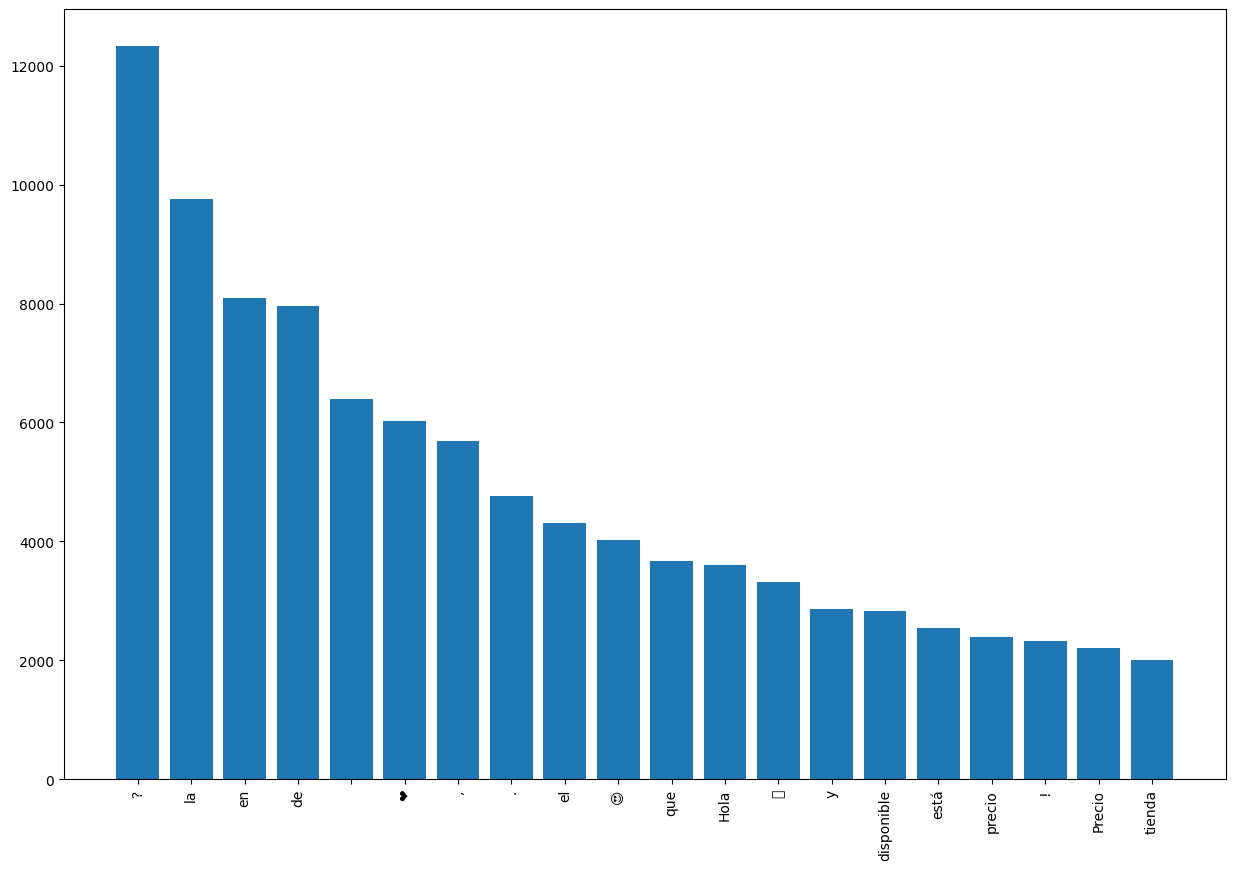

In [174]:
x,y = zip(*topwords)
plt.figure(figsize=(15,10))
plt.bar(x,y)
plt.xticks(rotation=90)
plt.show()

In [175]:
# stopwords en nltk
from nltk.corpus import stopwords

stop_words_nltk = set(stopwords.words('spanish'))


Size of new BoW= 28420


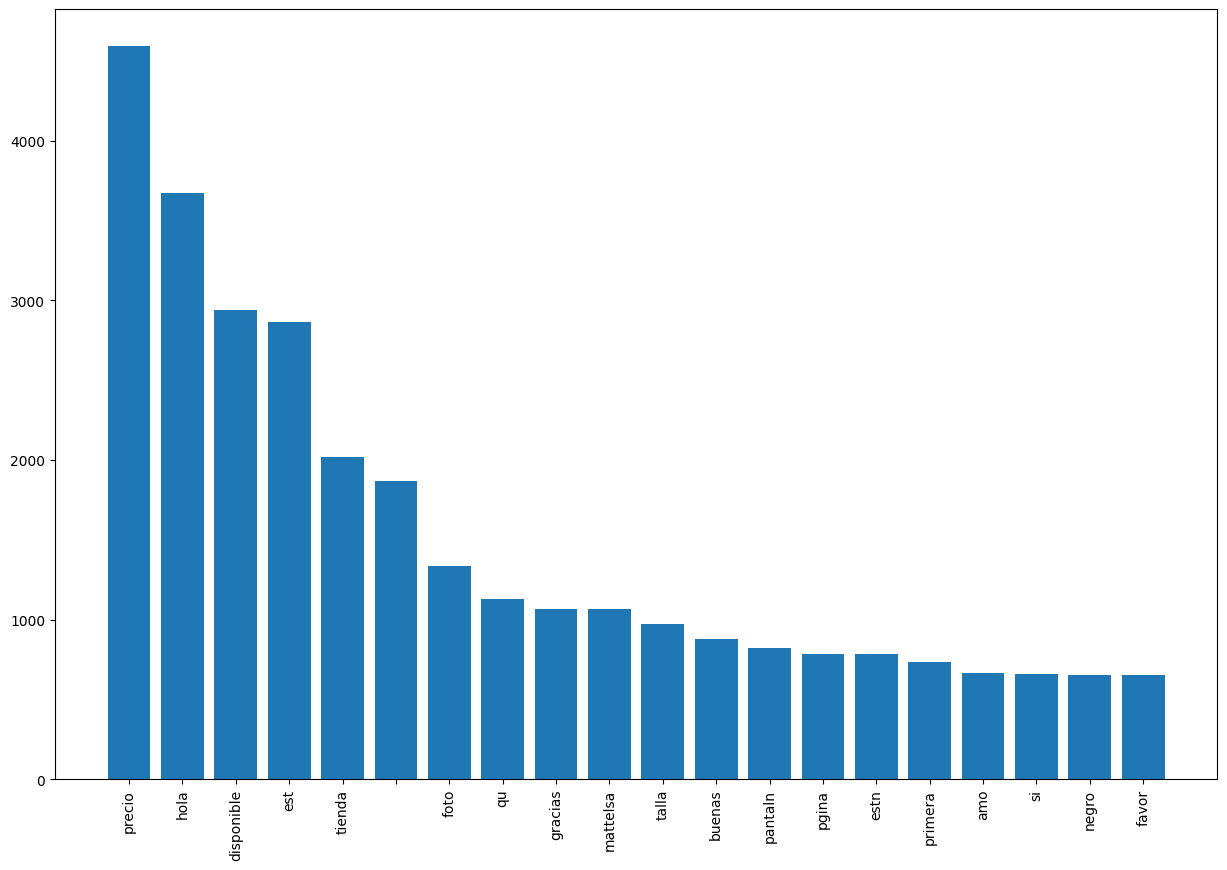

In [176]:
import re
#  TOKENIZAR con nltk,
# ELIMINAR tokens de long = 1
# ELIMINAR caracteres que no sean alfanumericos
# REMOVER stop words
# graficar los 20 términos más frecuentes:

# ya tokenizado en all_tokens
tokens = [w.lower() for w in all_tokens if len(w)>1]
tokens = [re.sub(r'[^A-Za-z0-9]+','',w) for w in tokens]
tokens = [w for w in tokens if w not in stop_words_nltk]

fdist = nltk.FreqDist(tokens)
topwords = fdist.most_common(20)
print('Size of new BoW=',len(fdist))
x,y = zip(*topwords)
plt.figure(figsize=(15,10))
plt.bar(x,y)
plt.xticks(rotation=90)
plt.show()

In [178]:
# Stemming con NLTK

from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer

porter = PorterStemmer()
lancaster = LancasterStemmer()


tokens = [lancaster.stem(w) for w in tokens]

fdist = nltk.FreqDist(tokens)
topwords = fdist.most_common(20)
print('Size of new BoW =',len(fdist))


Size of new BoW = 24878


In [179]:
# Lemmatization con NLTK
import nltk
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer

wordnet_lemmatizer = WordNetLemmatizer()

tokens = [wordnet_lemmatizer.lemmatize(w) for w in tokens ]

fdist = nltk.FreqDist(tokens)
topwords = fdist.most_common(20)
print('Size of new BoW =',len(fdist))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lriverosq\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Size of new BoW = 24826


In [181]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

vectorizer = TfidfVectorizer()

# Ajustar y transformar los documentos en una matriz TF-IDF
tfidf_matrix = vectorizer.fit_transform(tokens)

# Convertir las columnas de la matriz dispersa en un DataFrame disperso
df_tfidf_sparse = pd.DataFrame.sparse.from_spmatrix(tfidf_matrix, columns=vectorizer.get_feature_names_out())




# Mostrar el DataFr

print(df_tfidf_sparse)

        00  000  0000  00000  000000  00000000  0001  000lac  000ppp  002  \
0        0    0     0      0       0         0     0       0       0    0   
1        0    0     0      0       0         0     0       0       0    0   
2        0    0     0      0       0         0     0       0       0    0   
3        0    0     0      0       0         0     0       0       0    0   
4        0    0     0      0       0         0     0       0       0    0   
...     ..  ...   ...    ...     ...       ...   ...     ...     ...  ...   
128968   0    0     0      0       0         0     0       0       0    0   
128969   0    0     0      0       0         0     0       0       0    0   
128970   0    0     0      0       0         0     0       0       0    0   
128971   0    0     0      0       0         0     0       0       0    0   
128972   0    0     0      0       0         0     0       0       0    0   

        ...  zunigamaria2525  zunigavil  zurigb  zurlyhurtado  zyb90s  zz  

In [183]:
stop_words = set(stopwords.words('spanish'))

# Función de limpieza de texto
def limpiar_texto(text):
    text = re.sub(r'http\S+', '', text)  # Eliminar URLs
    text = re.sub(r'@\w+', '', text)     # Eliminar menciones
    text = re.sub(r'#\w+', '', text)     # Eliminar hashtags
    text = re.sub(r'\d+', '', text)      # Eliminar números
    text = re.sub(r'[^\w\s]', '', text)  # Eliminar puntuaciones
    text = text.lower()                  # Convertir a minúsculas
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Aplicar la limpieza a la columna de tuits
bd['texto_limpio'] = bd['text'].apply(limpiar_texto)

In [184]:
bd['texto_limpio']

0         lindo tal body rosa lila rojo favor saquen mis...
1                                                    parece
2                                           hola precio fis
3                                                       tal
4                    hola body manga larga tienda manizales
                                ...                        
232569                                                     
232570                          precio blusa blanca gracias
232571                             primera blusa referencia
232572                                  precio última falda
232573                                hagan tallas pequeñas
Name: texto_limpio, Length: 40247, dtype: object

In [ ]:
from textblob import TextBlob

# Función para obtener el sentimiento
def obtener_sentimiento(text):
    analisis = TextBlob(text)
    if analisis.sentiment.polarity > 0:
        return 'positivo'
    elif analisis.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'negativo'

# Aplicar el análisis de sentimiento en la columna limpia
bd['sentimento'] = bd['texto_limpio'].apply(obtener_sentimiento)

In [190]:
bd['sentimento'].value_counts()

sentimento
neutral     39108
positivo     1002
negativo      137
Name: count, dtype: int64

In [191]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Convertir el texto en una matriz de cuentas (CountVectorizer)
count_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = count_vectorizer.fit_transform(bd['texto_limpio'])

# Aplicar LDA para identificar los tópicos
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

# Mostrar los términos principales de cada tópico
def mostrar_topicos(modelo, count_vectorizer, n_palabras):
    palabras = count_vectorizer.get_feature_names_out()
    for idx, topico in enumerate(modelo.components_):
        print(f"Tópico {idx}:")
        print([palabras[i] for i in topico.argsort()[-n_palabras:]])

mostrar_topicos(lda, count_vectorizer, 10)

Tópico 0:
['tan', 'ustedes', 'si', 'pa', 'gracias', 'mejor', 'vida', 'mattelsa', 'ropa', 'amo']
Tópico 1:
['santa', 'tienda', 'dónde', 'tallas', 'buenos', 'bucaramanga', 'días', 'si', 'puedo', 'talla']
Tópico 2:
['jajaja', 'envíos', 'hacen', 'mujer', 'si', 'hola', 'necesito', 'hombre', 'disponibles', 'quiero']
Tópico 3:
['hola', 'día', 'cuanto', 'referencia', 'valor', 'web', 'siempre', 'vale', 'gracias', 'página']
Tópico 4:
['camisa', 'negro', 'primera', 'pantalón', 'buenas', 'foto', 'tienda', 'disponible', 'hola', 'precio']


In [192]:
pip install pipeline

Note: you may need to restart the kernel to use updated packages.Collecting pipeline




[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [194]:
from transformers import pipeline

# Cargar el pipeline de análisis de emociones
clasificador = pipeline('text-classification', model='j-hartmann/emotion-english-distilroberta-base')

# Analizar emociones en textos
bd['emociones'] = bd['text'].apply(lambda x: clasificador(x))

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Cargar el modelo SBERT
modelo = SentenceTransformer("all-MiniLM-L6-v2")

# Dataset de texto
texto = ["Estoy muy feliz", "Esto es muy frustrante", "Me siento triste"]

# Definir emociones base
emociones_base = {
    "alegría": "Esto me hace muy feliz y emocionado.",
    "tristeza": "Siento una profunda tristeza y desolación.",
    "enojo": "Estoy molesto y frustrado."
}

# Generar embeddings para textos y emociones base
emb_textos = modelo.encode(texto)
emb_emociones = modelo.encode(list(emociones_base.values()))

# Calcular similitud
for i, t in enumerate(texto):
    similitudes = cosine_similarity([emb_textos[i]], emb_emociones)
    emocion_predicha = list(emociones_base.keys())[np.argmax(similitudes)]
    print(f"Texto: {t}\nEmoción: {emocion_predicha}\n")

In [214]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Cargar el modelo SBERT
modelo = SentenceTransformer("all-MiniLM-L6-v2")


In [202]:
texto = bd['text'].tolist()

In [203]:
# Definir emociones base
emociones_base = {
    "alegría": "Esto me hace muy feliz y emocionado.",
    "tristeza": "Siento una profunda tristeza y desolación.",
    "enojo": "Estoy molesto y frustrado."
}

# Generar embeddings para textos y emociones base
emb_textos = modelo.encode(texto)
emb_emociones = modelo.encode(list(emociones_base.values()))

# Calcular similitud
for i, t in enumerate(texto):
    similitudes = cosine_similarity([emb_textos[i]], emb_emociones)
    emocion_predicha = list(emociones_base.keys())[np.argmax(similitudes)]
    print(f"Texto: {t}\nEmoción: {emocion_predicha}\n")

Texto: Muy lindo pero que tal ese body en rosa ,lila ,rojo, por favor no saquen los mismos colores ,blanco y negro , ya tengo todos los colores ya parece que solo tengo los mismo bodys 😩🤣
Emoción: alegría

Texto: Se parece a @cvillaloboss
Emoción: alegría

Texto: Hola que precio tiene el 1 por fis 😍😍🔥
Emoción: alegría

Texto: @anamhdzc que tal 😌
Emoción: alegría

Texto: Hola el body de manga larga esta en la tienda de Manizales?
Emoción: tristeza

Texto: Precio el outfit del pantalón blanco con el body blanco y la chaqueta
Emoción: tristeza

Texto: Precio del pantalon blanco por favor?
Emoción: tristeza

Texto: Precio de la blusa verde?
Emoción: enojo

Texto: Precio de la chaqueta por fa
Emoción: tristeza

Texto: La falda blanca no está en la página?
Emoción: enojo

Texto: La chaqueta solo es de mujer?
Emoción: tristeza

Texto: Hola tienen el cargo blanco en cc viva Barranquilla ?
Emoción: tristeza

Texto: Las sandalias de que marca son por favor
Emoción: tristeza

Texto: Que precio ti

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import pandas as pd

# Cargar el modelo LaBSE
modelo = SentenceTransformer("sentence-transformers/LaBSE")

# Generar vectores
vectores = modelo.encode(bd['text'].tolist())

# Agrupar con KMeans
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
clusters = kmeans.fit_predict(vectores)

# Añadir resultados al DataFrame
bd["cluster"] = clusters


                id_x      media.id  \
0       1.798408e+16  1.830930e+16   
1       1.787334e+16  1.830930e+16   
2       1.798180e+16  1.830930e+16   
3       1.825890e+16  1.830930e+16   
4       1.847023e+16  1.830930e+16   
...              ...           ...   
232569  1.798699e+16  1.788216e+16   
232570  1.807376e+16  1.786021e+16   
232571  1.786421e+16  1.786021e+16   
232572  1.793522e+16  1.786021e+16   
232573  1.801281e+16  1.786021e+16   

                                                     text  \
0       Muy lindo pero que tal ese body en rosa ,lila ...   
1                               Se parece a @cvillaloboss   
2                  Hola que precio tiene el 1 por fis 😍😍🔥   
3                                     @anamhdzc que tal 😌   
4       Hola el body de manga larga esta en la tienda ...   
...                                                   ...   
232569                                                  🔥   
232570                  Precio de la blusa blanca graci

In [208]:
bd.head(10)

id_x      media.id  \
0    1.798408e+16  1.830930e+16   
1    1.787334e+16  1.830930e+16   
2    1.798180e+16  1.830930e+16   
3    1.825890e+16  1.830930e+16   
4    1.847023e+16  1.830930e+16   
136  1.793919e+16  1.805109e+16   
137  1.833187e+16  1.805109e+16   
138  1.788287e+16  1.805109e+16   
139  1.805189e+16  1.805109e+16   
140  1.786284e+16  1.805109e+16   

                                                  text  \
0    Muy lindo pero que tal ese body en rosa ,lila ...   
1                            Se parece a @cvillaloboss   
2               Hola que precio tiene el 1 por fis 😍😍🔥   
3                                  @anamhdzc que tal 😌   
4    Hola el body de manga larga esta en la tienda ...   
136  Precio el outfit del pantalón blanco con el bo...   
137              Precio del pantalon blanco por favor?   
138                          Precio de la blusa verde?   
139                       Precio de la chaqueta por fa   
140              La falda blanca no está en la página?   

                                            imagen_cod  clasificacion  \
0    [[[0.6314803], [0.6451708], [0.6517461], [0.64...              0   
1    [[[0.6314803], [0.6451708], [0.6517461], [0.64...              0   
2    [[[0.6314803], [0.6451708], [0.6517461], [0.64...              0   
3    [[[0.6314803], [0.6451708], [0.6517461], [0.64...              0   
4    [[[0.6314803], [0.6451708], [0.6517461], [0.64...              0   
136  [[[0.617944], [0.67451876], [0.69645417], [0.6...              0   
137  [[[0.617944], [0.67451876], [0.69645417], [0.6...              0   
138  [[[0.617944], [0.67451876], [0.69645417], [0.6...              0   
139  [[[0.617944], [0.67451876], [0.69645417], [0.6...              0   
140  [[[0.617944], [0.67451876], [0.69645417], [0.6...              0   

                                          texto_limpio sentimento  \
0    lindo tal body rosa lila rojo favor saquen mis...    neutral   
1                                               parece    neutral   
2                                      hola precio fis    neutral   
3                                                  tal    neutral   
4               hola body manga larga tienda manizales    neutral   
136  precio outfit pantalón blanco body blanco chaq...    neutral   
137                       precio pantalon blanco favor    neutral   
138                                 precio blusa verde    neutral   
139                                 precio chaqueta fa    neutral   
140                                falda blanca página    neutral   

                                             emociones  cluster  
0    [{'label': 'neutral', 'score': 0.4913618862628...        0  
1    [{'label': 'neutral', 'score': 0.6330802440643...        1  
2    [{'label': 'neutral', 'score': 0.6039230227470...        0  
3     [{'label': 'fear', 'score': 0.3464270830154419}]        1  
4    [{'label': 'neutral', 'score': 0.8224393725395...        0  
136  [{'label': 'neutral', 'score': 0.8590807914733...        0  
137  [{'label': 'neutral', 'score': 0.8055391907691...        0  
138  [{'label': 'neutral', 'score': 0.7472785115242...        0  
139  [{'label': 'disgust', 'score': 0.2633645236492...        0  
140  [{'label': 'neutral', 'score': 0.6340171098709...        0

In [209]:
bd['cluster'].value_counts()

cluster
0    18367
2    11023
1    10857
Name: count, dtype: int64

In [212]:
bd[bd['cluster']== 0]

id_x      media.id  \
0       1.798408e+16  1.830930e+16   
2       1.798180e+16  1.830930e+16   
4       1.847023e+16  1.830930e+16   
136     1.793919e+16  1.805109e+16   
137     1.833187e+16  1.805109e+16   
...              ...           ...   
232566  1.805724e+16  1.788216e+16   
232567  1.828273e+16  1.788216e+16   
232570  1.807376e+16  1.786021e+16   
232571  1.786421e+16  1.786021e+16   
232572  1.793522e+16  1.786021e+16   

                                                     text  \
0       Muy lindo pero que tal ese body en rosa ,lila ...   
2                  Hola que precio tiene el 1 por fis 😍😍🔥   
4       Hola el body de manga larga esta en la tienda ...   
136     Precio el outfit del pantalón blanco con el bo...   
137                 Precio del pantalon blanco por favor?   
...                                                   ...   
232566                      Precio de balón de basquet? 😏   
232567                                  Precio del buzo ?   
232570                  Precio de la blusa blanca gracias   
232571         Y esa primera blusa? cual es la referencia   
232572                         Precio de la última falda?   

                                               imagen_cod  clasificacion  \
0       [[[0.6314803], [0.6451708], [0.6517461], [0.64...              0   
2       [[[0.6314803], [0.6451708], [0.6517461], [0.64...              0   
4       [[[0.6314803], [0.6451708], [0.6517461], [0.64...              0   
136     [[[0.617944], [0.67451876], [0.69645417], [0.6...              0   
137     [[[0.617944], [0.67451876], [0.69645417], [0.6...              0   
...                                                   ...            ...   
232566  [[[0.6919207], [0.676356], [0.6787989], [0.682...              0   
232567  [[[0.6919207], [0.676356], [0.6787989], [0.682...              0   
232570  [[[0.56560886], [0.5850501], [0.5797957], [0.5...              0   
232571  [[[0.56560886], [0.5850501], [0.5797957], [0.5...              0   
232572  [[[0.56560886], [0.5850501], [0.5797957], [0.5...              0   

                                             texto_limpio sentimento  \
0       lindo tal body rosa lila rojo favor saquen mis...    neutral   
2                                         hola precio fis    neutral   
4                  hola body manga larga tienda manizales    neutral   
136     precio outfit pantalón blanco body blanco chaq...    neutral   
137                          precio pantalon blanco favor    neutral   
...                                                   ...        ...   
232566                               precio balón basquet    neutral   
232567                                        precio buzo    neutral   
232570                        precio blusa blanca gracias    neutral   
232571                           primera blusa referencia    neutral   
232572                                precio última falda    neutral   

                                                emociones  cluster  
0       [{'label': 'neutral', 'score': 0.4913618862628...        0  
2       [{'label': 'neutral', 'score': 0.6039230227470...        0  
4       [{'label': 'neutral', 'score': 0.8224393725395...        0  
136     [{'label': 'neutral', 'score': 0.8590807914733...        0  
137     [{'label': 'neutral', 'score': 0.8055391907691...        0  
...                                                   ...      ...  
232566  [{'label': 'neutral', 'score': 0.8586005568504...        0  
232567  [{'label': 'neutral', 'score': 0.8030031919479...        0  
232570  [{'label': 'neutral', 'score': 0.7570294141769...        0  
232571  [{'label': 'neutral', 'score': 0.7174479365348...        0  
232572  [{'label': 'neutral', 'score': 0.5739757418632...        0  

[18367 rows x 9 columns]

In [221]:
# Función de limpieza de texto
def limpiar_texto(text):
    text = re.sub(r'http\S+', '', text)  # Eliminar URLs
    text = re.sub(r'@\w+', '', text)     # Eliminar menciones
    text = re.sub(r'#\w+', '', text)     # Eliminar hashtags
    text = re.sub(r'\d+', '', text)      # Eliminar números
    text = re.sub(r'[^\w\s]', '', text)  # Eliminar puntuaciones
    text = text.lower()                  # Convertir a minúsculas
    return text

# Aplicar la limpieza a la columna de tuits
bd['texto_limpio2'] = bd['text'].apply(limpiar_texto)

In [222]:
texto = bd['texto_limpio2'].tolist()

Modelo preentrenado SBERT

In [224]:
# Definir emociones base
emociones_base = {
    "positivo": ['Que estilo', 'La tienda más cool del mundo', 'Me merecen esos jogger',  'lo hacen muy bien', 'bonita la ropa', 'me encanta su contenido', 'La mejor ropa','Belleza', 'Wow 😍❤️', 'Me encanta el 3','Últimamente me gusta sus prendas ','Eso si es verdad, excelente calidad en las telas, amo las camisas blancas de ustedes, tengo 3 ','La calidad de las telas si ha mejorado muchísimo. 😍😍😍😍😍','Amo ese vestido blanco lo veo y lo quiero 😍'],
    "neutro": ['precio por favor',  'el top está en la tienda','item de la camiseta', 'lo tienen en laureles medellín talla s' , 'por el sitio web se pueden comprar?',
               'donde están ubicados', 'que item tiene el pantalon'],
    "negativo": ['Hagan tallas más pequeñas',  'la otra vez  no habían', 'Jamás los dejan entrar', 'Traten de que hagan talla grandes', 'la ropa esta cara',
                  'la pagina no deja comprar', 'la ropa esta fea','Buenas tardes realice un pedido y me lo enviaron por TCC pero mirando la guía dice que llevan 2 intentos y no encuentran mi dirección',
                  'Cuando algo que no sea oversize ? 😢','Se les acabaron las ideas? 🥴','saquen otra vez vestiditos sueltos como los de hace años ,hacen falta 😢',
                  'Tuve un problema con una compra me gustaría resolverlo',
                  'Creo que sus camisetas y sus últimas publicaciones acerca de la "friendzone" atentan terriblemente contra el derecho de decir NO de una mujer']

}

# Generar embeddings para emociones base
emociones_textos = [item for sublist in emociones_base.values() for item in sublist]  # Aplanar la lista de emociones
emb_emociones = modelo.encode(emociones_textos)

# Crear un diccionario de emociones con índices
emocion_indices = list(emociones_base.keys())
emocion_dict = {}
index = 0
for emocion, frases in emociones_base.items():
    emocion_dict[emocion] = list(range(index, index + len(frases)))
    index += len(frases)

def predecir_emocion(texto):
    try:
        emb_texto = modelo.encode([texto])
        similitudes = cosine_similarity(emb_texto, emb_emociones)
        max_index = np.argmax(similitudes)  # Obtener el índice de la máxima similitud
        emocion_predicha = None
        for emocion, indices in emocion_dict.items():
            if max_index in indices:
                emocion_predicha = emocion
                break
        return emocion_predicha
    except Exception as e:
        print(f"Error procesando el texto: {texto}, {e}")
        return None

# Aplicar al dataframe
bd['emocion'] = bd['texto_limpio2'].apply(predecir_emocion)

In [227]:
bd['emocion'].value_counts()

emocion
positivo    21733
neutro      12219
negativo     6295
Name: count, dtype: int64

In [230]:
bd[bd['emocion'] == 'negativo'].tail(10)

id_x      media.id  \
231947  1.792076e+16  1.806088e+16   
232142  1.792785e+16  1.805216e+16   
232200  1.794484e+16  1.788059e+16   
232400  1.809166e+16  1.804558e+16   
232403  1.785385e+16  1.804558e+16   
232408  1.804600e+16  1.796234e+16   
232410  1.809705e+16  1.796234e+16   
232555  1.786877e+16  1.793222e+16   
232556  1.792963e+16  1.793222e+16   
232573  1.801281e+16  1.786021e+16   

                                                     text  \
231947    La blanca con el oso esta disponible en Armenia   
232142  Buenas noches, cual es la referencia de la cam...   
232200                                         Uyyyyy 🔥🔥🔥   
232400  Esta disponible en talla s en la tienda de Man...   
232403                 No aparecen en la página todavía ?   
232408           Hola, qué precio la última falda blanca?   
232410  Hola! Con q ref encuentro la Verde y la última...   
232555  Hola buenos días. Me puedes dar la información...   
232556  https://www.mattelsa.net/ en la página encuent...   
232573                        Hagan tallas más pequeñas 😢   

                                               imagen_cod  clasificacion  \
231947  [[[0.77533823], [0.5313065], [0.2607442], [0.8...              0   
232142  [[[0.509168], [0.48205686], [0.4922449], [0.51...              0   
232200  [[[0.33121002], [0.32062286], [0.30493817], [0...              0   
232400  [[[0.2463598], [0.24977604], [0.2251458], [0.3...              0   
232403  [[[0.2463598], [0.24977604], [0.2251458], [0.3...              0   
232408  [[[0.78842425], [0.7925839], [0.78199667], [0....              0   
232410  [[[0.78842425], [0.7925839], [0.78199667], [0....              0   
232555  [[[0.6075318], [0.35438174], [0.6408423], [0.7...              0   
232556  [[[0.6075318], [0.35438174], [0.6408423], [0.7...              0   
232573  [[[0.56560886], [0.5850501], [0.5797957], [0.5...              0   

                                             texto_limpio sentimento  \
231947                      blanca oso disponible armenia    neutral   
232142  buenas noches referencia camiseta verde pedirl...    neutral   
232200                                             uyyyyy    neutral   
232400                disponible talla s tienda manizales    neutral   
232403                            aparecen página todavía    neutral   
232408                    hola precio última falda blanca    neutral   
232410     hola q ref encuentro verde última blanca porfa    neutral   
232555  hola buenos días puedes dar información realiz...    neutral   
232556                 página encuentran toda información    neutral   
232573                              hagan tallas pequeñas    neutral   

                                                emociones  cluster  \
231947  [{'label': 'neutral', 'score': 0.4658330082893...        0   
232142  [{'label': 'neutral', 'score': 0.3271772861480...        0   
232200  [{'label': 'neutral', 'score': 0.5067565441131...        1   
232400  [{'label': 'neutral', 'score': 0.7438187599182...        0   
232403  [{'label': 'neutral', 'score': 0.6983947157859...        0   
232408  [{'label': 'neutral', 'score': 0.7509064674377...        0   
232410    [{'label': 'joy', 'score': 0.7966687679290771}]        0   
232555  [{'label': 'neutral', 'score': 0.4627950787544...        0   
232556  [{'label': 'neutral', 'score': 0.7391416430473...        0   
232573  [{'label': 'neutral', 'score': 0.8817042112350...        1   

                                            texto_limpio2   emocion  
231947    la blanca con el oso esta disponible en armenia  negativo  
232142  buenas noches cual es la referencia de la cami...  negativo  
232200                                            uyyyyy   negativo  
232400  esta disponible en talla s en la tienda de man...  negativo  
232403                  no aparecen en la página todavía   negativo  
232408             hola qué precio la última falda blanca  negativo  
232410  hola con q ref encuentro l

In [231]:
# Cargar el modelo LaBSE
modelo = SentenceTransformer("sentence-transformers/LaBSE")

# Generar vectores
vectores = modelo.encode(bd['texto_limpio2'].tolist())

# Agrupar con KMeans
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
clusters = kmeans.fit_predict(vectores)

# Añadir resultados al DataFrame
bd["cluster"] = clusters

In [1]:
bd[bd['cluster'] == 0].tail(10)

NameError: name 'bd' is not defined

In [234]:

# Función de limpieza que conserva emojis
def limpiar_texto_con_emojis(text):
    text = re.sub(r'http\S+', '', text)  # Eliminar URLs
    text = re.sub(r'@\w+', '', text)     # Eliminar menciones
    text = re.sub(r'#\w+', '', text)     # Eliminar hashtags
    text = re.sub(r'\d+', '', text)      # Eliminar números
    text = re.sub(r'[^\w\s\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF]', '', text)
    text = text.lower()                  # Convertir a minúsculas
    return text

bd['texto_limpio3'] = bd['text'].apply(limpiar_texto)

In [236]:


# Generar vectores
vectores = modelo.encode(bd['texto_limpio3'].tolist())

# Agrupar con KMeans
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
clusters = kmeans.fit_predict(vectores)

# Añadir resultados al DataFrame
bd["cluster"] = clusters

In [215]:
from sentence_transformers import SentenceTransformer

# Cargar un modelo compatible
modelo_beto_sbert = SentenceTransformer('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')

print("Modelo BETO-SBERT alternativo cargado con éxito.")

c:\Users\lriverosq\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\lriverosq\.cache\huggingface\hub\models--sentence-transformers--paraphrase-multilingual-mpnet-base-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


KeyboardInterrupt: 